### Inverted Pendulum on cart


### System model
ref: https://www.researchgate.net/publication/273170289_Optimal_Control_of_Nonlinear_Inverted_Pendulum_System_Using_PID_Controller_and_LQR_Performance_Analysis_Without_and_With_Disturbance_Input

$\frac{\mathrm{d} \boldsymbol{x}}{\mathrm{d} t}=\frac{\mathrm{d}}{\mathrm{d} t}\left[\begin{array}{l}x_{1} \\ x_{2} \\ x_{3} \\ x_{4}\end{array}\right]=\frac{\mathrm{d}}{\mathrm{d} t}\left[\begin{array}{c}\theta \\ \dot{\theta} \\ x \\ \dot{x}\end{array}\right]=\left[\begin{array}{c}f_{1} \\ f_{2} \\ f_{3} \\ f_{4}\end{array}\right] = \left[\begin{array}{c} x_2\\ \frac{u \cos x_{1}-(M+m) g \sin x_{1}+m l\left(\cos x_{1} \sin x_{1}\right) x_{2}^{2}}{m l \cos ^{2} x_{1}-(M+m) l}  \\ x_4 \\ \frac{u+m l(\sin x_1) x_2^{2}-m g \cos x_1 \sin x_1}{M+m-m \cos ^{2} x_1} \end{array}\right]$

In [1]:
import casadi as ca
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def inverted_pendulum_nonlinear_ode(x, u):
    M  = 2.4
    m = 0.23
    l = 0.36
    g = 9.81

    dx1_dt = x[1]
    dx2_dt = ( u * ca.cos(x[0]) - (M+m) * g * ca.sin(x[0]) + m * l * ca.cos(x[0]) *ca.sin(x[0])*x[1]**2) / (m*l*ca.cos(x[0])**2 - (M+m) *l)
    dx3_dt = x[3]
    dx4_dt = (u + m*l * ca.sin(x[0]) * x[1]**2 - m*g*ca.cos(x[0])*ca.sin(x[0]))/(M+m-m*ca.cos(x[0])**2)
    rhs = [dx1_dt,
           dx2_dt,
           dx3_dt,
           dx4_dt
           ]
    
    return ca.vertcat(*rhs)

In [3]:
x_SX = ca.SX.sym("x_SX", 4)
u_SX = ca.SX.sym("u_SX", 1)

ode = ca.Function("ode_func", [x_SX, u_SX], [inverted_pendulum_nonlinear_ode(x_SX, u_SX)])
delta_t = 0.1
# N = 5

In [4]:
ode.sx_in()

[SX([x_SX_0, x_SX_1, x_SX_2, x_SX_3]), SX(u_SX)]

In [5]:
def integrator_rk4(f, x, u, delta_t):
    '''
    This function calculates the integration of stage cost with RK4.
    '''

    k1 = f(x, u)
    k2 = f(x + delta_t / 2 * k1, u)
    k3 = f(x + delta_t / 2 * k2, u)
    k4 = f(x + delta_t * k3, u)


    x_next = x + delta_t / 6 * (k1 + 2 * k2 + 2 * k3 + k4)
    return x_next

In [6]:
sys_int = integrator_rk4(ode, x_SX, u_SX, delta_t)
sys_int_fn = ca.Function("sys_int_fn",[x_SX, u_SX],[sys_int])

In [7]:
A = ca.jacobian(sys_int,x_SX)
B = ca.jacobian(sys_int,u_SX)

A_fn = ca.Function("A_fn",[x_SX,u_SX],[A])
B_fn = ca.Function("B_fn",[x_SX,u_SX],[B])

In [8]:
x0 =  ca.SX.sym("x0_SX", 4)
u0 = ca.SX.sym("u0_SX", 1)

xk =  ca.SX.sym("xk_SX", 4)
uk = ca.SX.sym("uk_SX", 1)


x_next = sys_int_fn(x0,u0) + A_fn(x0,u0) @(xk - x0) + B_fn(x0,u0) @ (uk - u0)
x_next_fn_lin = ca.Function("x_next_fn_lin", [x0,xk,u0,uk],[x_next])

### Test 1: state evolution

(a) constant input u = 0, system evolves by only considering linear term $Ax_k + Bu_k$

In [9]:
N = 100

x_init = np.array([[0],[0],[0],[0]])


x_next = A_fn(x0,u0) @ xk +  B_fn(x0,u0) @ uk
x_next_fn = ca.Function("x_next_fn",[x0,xk,u0,uk],[x_next])

In [10]:
x_list1 = []
x_list1.append(x_init.flatten().tolist())

In [11]:
uk = np.array([[0.1]])
xk = x_init
for i in range(N):
    if i == 0:
        x0 = np.array([[0],[0],[0],[0]])
        u0 = uk
    
    x_next = x_next_fn(x0,xk,u0,uk)
    print(x_next)
    x_list1.append(x_next.full().flatten().tolist())
    x0 = xk
    xk = x_next

[-0.000593104, -0.0121501, 0.000208787, 0.0041848]
[-0.00255245, -0.0280187, 0.000840815, 0.00848667]
[-0.00647744, -0.0524574, 0.00191495, 0.0130583]
[-0.0135685, -0.0929382, 0.00346899, 0.0181349]
[-0.0259939, -0.161833, 0.00557114, 0.0241049]
[-0.0475511, -0.280166, 0.00834065, 0.0316248]
[-0.0848191, -0.483894, 0.0119829, 0.0417973]
[-0.149122, -0.834096, 0.0168454, 0.0563895]
[-0.259748, -1.43159, 0.0234868, 0.0777693]
[-0.448605, -2.4278, 0.0326643, 0.106662]
[-0.76414, -3.98378, 0.0446936, 0.129333]
[-1.26302, -6.0415, 0.0560984, 0.0722855]
[-1.96972, -8.00644, 0.0504528, -0.244104]
[-2.83069, -8.77379, -0.00190152, -0.782338]
[-3.49536, -2.57905, -0.0749929, -0.376304]
[-3.13659, 9.06804, -0.0536362, 0.695034]
[-1.87753, 15.4257, 0.0226044, 0.794968]
[-0.154762, 17.72, 0.10802, 0.695697]
[1.69977, 20.4047, 0.107258, -0.426076]
[3.80762, 23.358, 0.2064, 2.62759]
[5.47158, 6.18735, 0.291563, -2.22599]
[6.60035, 18.6495, -0.0357094, -1.43812]
[9.30076, 37.4848, -0.185093, -1.61411

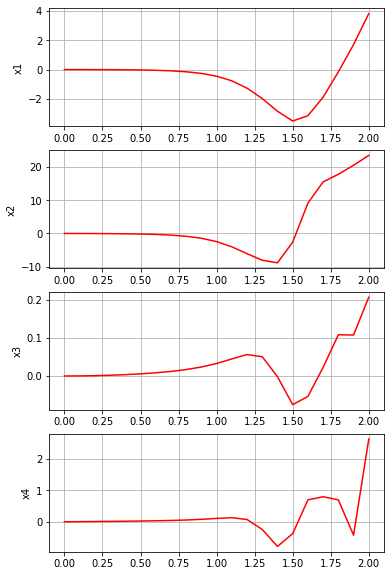

In [12]:
x_plot = np.array(x_list1)
N_plot = 20
tgrid = [delta_t * k for k in range(N_plot + 1)]
plt.figure(1, figsize=(6, 10))
plt.clf()
for i in range (4):
    plt.subplot( str(4) + str(1) + str(i + 1) )
    plt.grid()
    x_opt = x_plot[:N_plot+1,i]
    plt.plot(tgrid, x_opt, 'r')
    plt.ylabel('x' + str(i + 1))

In [13]:
x_list2 = []
x_list2.append(x_init.flatten().tolist())

In [14]:
uk = np.array([[0.1]])
xk = x_init

for i in range(N):
    x_next = x_next_fn_lin(xk,xk,uk,uk)
#     print(x_next)
    x_list2.append(x_next.full().flatten().tolist())
    xk = x_next

In [15]:
x_plot = np.array(x_list1)
N_plot = 20
tgrid = [delta_t * k for k in range(N_plot + 1)]

In [16]:
x_list2

[[0, 0, 0, 0],
 [-0.0005931044726626505,
  -0.012150104508938298,
  0.0002087867103728716,
  0.004184801695032171],
 [-0.002552447119481473,
  -0.028018666873550924,
  0.0008408146015742454,
  0.008486668406303565],
 [-0.0064774377159006365,
  -0.052457289124416585,
  0.0019149536747618658,
  0.013058316142561898],
 [-0.013568471509037972,
  -0.09293772264389379,
  0.0034689868446849364,
  0.018134802121685244],
 [-0.02599374905020419,
  -0.16183109060212353,
  0.005571118807614058,
  0.024104584716047404],
 [-0.047550633114001165,
  -0.28016149033308313,
  0.008340578634003228,
  0.031623951762608994],
 [-0.08481777117633979,
  -0.48388110234781656,
  0.011982723112948304,
  0.04179486882771931],
 [-0.14911923655180678,
  -0.8340716557662979,
  0.016844757845026998,
  0.05638423252895748],
 [-0.2597444248282574,
  -1.4316514835761194,
  0.023485760284843584,
  0.07777334715096529],
 [-0.4486561730467257,
  -2.429612773234763,
  0.03267025088636222,
  0.10690968821762434],
 [-0.7650067

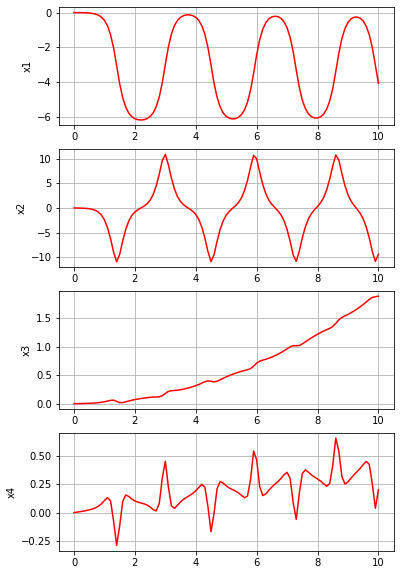

In [17]:
x_plot = np.array(x_list2)
tgrid = [delta_t * k for k in range(N + 1)]
plt.figure(1, figsize=(6, 10))
plt.clf()
for i in range (4):
    plt.subplot( str(4) + str(1) + str(i + 1) )
    plt.grid()
    x_opt = x_plot[:,i]
    plt.plot(tgrid, x_opt, 'r')
    plt.ylabel('x' + str(i + 1))

In [18]:
x_list3 = []
x_list3.append(x_init.flatten().tolist())

In [19]:
uk = np.array([[0.1]])
xk = x_init

for i in range(N):
    if i == 0:
        x0 = np.array([[0],[0],[0],[0]])
        u0 = uk

    x_next = x_next_fn_lin(x0,xk,u0,uk)
    print(x_next)
    x_list3.append(x_next.full().flatten().tolist())
    x0 = xk
    xk = x_next

[-0.000593104, -0.0121501, 0.000208787, 0.0041848]
[-0.00255245, -0.0280187, 0.000840815, 0.00848667]
[-0.00647745, -0.0524575, 0.00191495, 0.0130583]
[-0.0135685, -0.0929389, 0.003469, 0.018135]
[-0.0259941, -0.161838, 0.00557117, 0.0241056]
[-0.0475527, -0.280197, 0.00834089, 0.0316292]
[-0.084829, -0.484071, 0.0119844, 0.0418229]
[-0.149178, -0.835052, 0.0168534, 0.0565295]
[-0.260046, -1.4366, 0.0235305, 0.078509]
[-0.45015, -2.4533, 0.0328926, 0.110437]
[-0.771824, -4.10554, 0.045833, 0.14741]
[-1.29791, -6.54496, 0.0612749, 0.146832]
[-2.10132, -9.58933, 0.0696459, -0.0214966]
[-3.21757, -12.5515, 0.0480077, -0.42089]
[-4.45594, -10.9726, 0.00508534, -0.263458]
[-5.30573, -6.53107, 0.0106231, 0.262418]
[-5.85931, -4.72336, 0.0363577, 0.220992]
[-6.2832, -3.9751, 0.0565532, 0.187845]
[-6.69696, -4.51831, 0.0753462, 0.193237]
[-7.22854, -6.31456, 0.0955917, 0.205763]
[-7.99467, -9.1384, 0.113018, 0.10706]
[-9.07311, -12.4465, 0.106632, -0.28278]
[-10.4259, -13.5226, 0.0595347, -0.5

In [20]:
x_plot = np.array(x_list3)
tgrid = [delta_t * k for k in range(N + 1)]

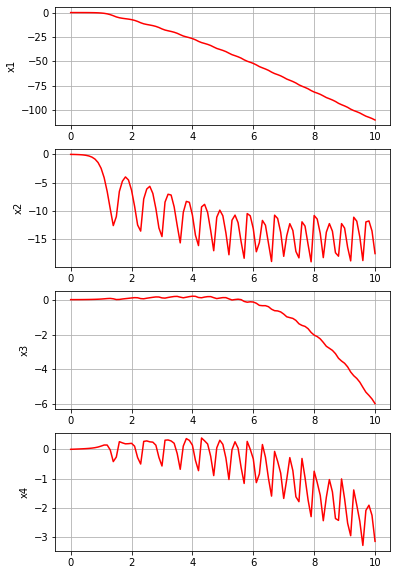

In [21]:
plt.figure(1, figsize=(6, 10))
plt.clf()
for i in range (4):
    plt.subplot( str(4) + str(1) + str(i + 1) )
    plt.grid()
    x_opt = x_plot[:,i]
    plt.plot(tgrid, x_opt, 'r')
    plt.ylabel('x' + str(i + 1))

In [22]:
x_list4 = []
x_list4.append(x_init.flatten().tolist())

In [23]:
xk = x_init
for i in range(N):    
    x_next_real = integrator_rk4(ode,xk,uk,delta_t)
    x_list4.append(x_next_real.full().flatten().tolist())
    xk = x_next_real
    

In [24]:
x_plot

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [-5.93104473e-04, -1.21501045e-02,  2.08786710e-04,
         4.18480170e-03],
       [-2.55244773e-03, -2.80186877e-02,  8.40814686e-04,
         8.48667129e-03],
       [-6.47744599e-03, -5.24574742e-02,  1.91495484e-03,
         1.30583425e-02],
       [-1.35685331e-02, -9.29388981e-02,  3.46899569e-03,
         1.81349720e-02],
       [-2.59941236e-02, -1.61837755e-01,  5.57117324e-03,
         2.41055578e-02],
       [-4.75527242e-02, -2.80197471e-01,  8.34088513e-03,
         3.16292426e-02],
       [-8.48289789e-02, -4.84070564e-01,  1.19843758e-02,
         4.18228613e-02],
       [-1.49177940e-01, -8.35051841e-01,  1.68534499e-02,
         5.65295159e-02],
       [-2.60045757e-01, -1.43660294e+00,  2.35305027e-02,
         7.85089747e-02],
       [-4.50150300e-01, -2.45330360e+00,  3.28925624e-02,
         1.10436764e-01],
       [-7.71824335e-01, -4.10554283e+00,  4.58329724e-02,
      

In [25]:
x_plot = np.array(x_list4)
tgrid = [delta_t * k for k in range(N + 1)]
# x1_plot = x_plot[:,0]
# x2_plot = x_plot[:,1]
# x3_plot = x_plot[:,2]
# x4_plot = x_plot[:,3]

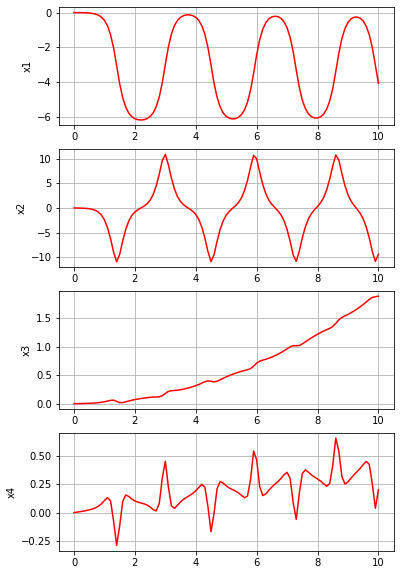

In [26]:
plt.figure(1, figsize=(6, 10))
plt.clf()
for i in range (4):
    plt.subplot( str(4) + str(1) + str(i + 1) )
    plt.grid()
    x_opt = x_plot[:,i]
    plt.plot(tgrid, x_opt, 'r')
    plt.ylabel('x' + str(i + 1))

### Test 2: Evolution within a short interval

#### $\Delta_{sample} = 0.1 s$, $\Delta_{interval} = 1s$

In [27]:
100 % 10

0

In [28]:
N

100

In [29]:
x_list1 = []
x_list1.append(x_init.flatten().tolist())

x_list2 = []
x_list2.append(x_init.flatten().tolist())

uk = np.array([[0.1]])
xk_real = x_init
xk_appr = x_init

N_delta = 10 # give accurate state every 1 second.

for i in range(N):
    if i == 0:
        x0 = x_init
        u0 = uk

        
    x_next_real = integrator_rk4(ode,xk_real,uk,delta_t)
    x_list1.append(x_next_real.full().flatten().tolist())

    
    if i % N_delta == 0:
        print(i)
        xk_appr = xk_real
        x0 = xk_appr
    
    x_next_appr = x_next_fn_lin(x0,xk_appr,u0,uk)
#     print(x_next)
    x_list2.append(x_next_appr.full().flatten().tolist())

    
    
    xk_real = x_next_real
    
    x0 = xk_appr
    xk_appr = x_next_appr

0
10
20
30
40
50
60
70
80
90


#### $\Delta_{sample} = 0.1 s$, $\Delta_{interval} = 1s$

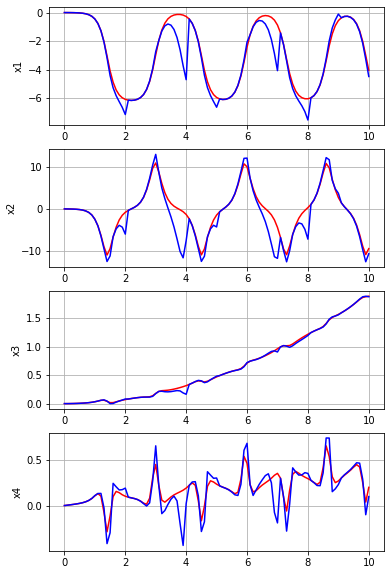

In [30]:
x_plot_real = np.array(x_list1)
tgrid = [delta_t * k for k in range(N + 1)]

x_plot_appr = np.array(x_list2)
tgrid = [delta_t * k for k in range(N + 1)]

plt.figure(1, figsize=(6, 10))
plt.clf()
for i in range (4):
    plt.subplot( str(4) + str(1) + str(i + 1) )
    plt.grid()
    x_opt_real = x_plot_real[:,i]
    x_opt_appr = x_plot_appr[:,i]
    plt.plot(tgrid, x_opt_real, 'r')
    plt.plot(tgrid, x_opt_appr, 'b')
    plt.ylabel('x' + str(i + 1))

#### without updating $x_0$ within $\Delta_{interval}$

In [31]:
x_list1 = []
x_list1.append(x_init.flatten().tolist())

x_list2 = []
x_list2.append(x_init.flatten().tolist())

uk = np.array([[0.1]])
xk_real = x_init
xk_appr = x_init

N_delta = 10 # give accurate state every 1 second.

for i in range(N):
#     if i == 0:
#         x0 = x_init
#         u0 = uk
    if i % N_delta == 0:
        print(i)
        xk_appr = xk_real
        x0 = xk_appr
        
    x_next_real = integrator_rk4(ode,xk_real,uk,delta_t)
    x_list1.append(x_next_real.full().flatten().tolist())

    

    
    x_next_appr = x_next_fn_lin(x0,xk_appr,u0,uk)
#     print(x_next)
    x_list2.append(x_next_appr.full().flatten().tolist())

    
    
    xk_real = x_next_real
    
#     x0 = xk_appr
    xk_appr = x_next_appr

0
10
20
30
40
50
60
70
80
90


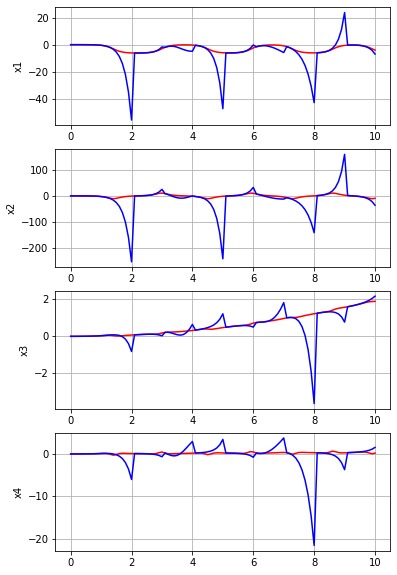

In [32]:
x_plot_real = np.array(x_list1)
tgrid = [delta_t * k for k in range(N + 1)]

x_plot_appr = np.array(x_list2)
tgrid = [delta_t * k for k in range(N + 1)]

plt.figure(1, figsize=(6, 10))
plt.clf()
for i in range (4):
    plt.subplot( str(4) + str(1) + str(i + 1) )
    plt.grid()
    x_opt_real = x_plot_real[:,i]
    x_opt_appr = x_plot_appr[:,i]
    plt.plot(tgrid, x_opt_real, 'r')
    plt.plot(tgrid, x_opt_appr, 'b')
    plt.ylabel('x' + str(i + 1))

#### $\Delta_{sample} = 0.01 s$, $\Delta_{interval} = 1s$

In [33]:
x_SX = ca.SX.sym("x_SX", 4)
u_SX = ca.SX.sym("u_SX", 1)

ode = ca.Function("ode_func", [x_SX, u_SX], [inverted_pendulum_nonlinear_ode(x_SX, u_SX)])
delta_t = 0.01

sys_int = integrator_rk4(ode, x_SX, u_SX, delta_t)
sys_int_fn = ca.Function("sys_int_fn",[x_SX, u_SX],[sys_int])

A = ca.jacobian(sys_int,x_SX)
B = ca.jacobian(sys_int,u_SX)

A_fn = ca.Function("A_fn",[x_SX,u_SX],[A])
B_fn = ca.Function("B_fn",[x_SX,u_SX],[B])

x0 =  ca.SX.sym("x0_SX", 4)
u0 = ca.SX.sym("u0_SX", 1)

xk =  ca.SX.sym("xk_SX", 4)
uk = ca.SX.sym("uk_SX", 1)


x_next = sys_int_fn(x0,u0) + A_fn(x0,u0) @(xk - x0) + B_fn(x0,u0) @ (uk - u0) 
x_next_fn_lin = ca.Function("x_next_fn_lin", [x0,xk,u0,uk],[x_next])

In [34]:
x_list1 = []
x_list1.append(x_init.flatten().tolist())

x_list2 = []
x_list2.append(x_init.flatten().tolist())

uk = np.array([[0.1]])
xk_real = x_init
xk_appr = x_init

N_delta = 100 # give accurate state every 1 second.
N = 1000
for i in range(N):
    if i == 0:
        x0 = x_init
        u0 = uk

        
    x_next_real = integrator_rk4(ode,xk_real,uk,delta_t)
    x_list1.append(x_next_real.full().flatten().tolist())

    
    if i % N_delta == 0:
        print(i)
        xk_appr = xk_real
        x0 = xk_appr
    
    x_next_appr = x_next_fn_lin(x0,xk_appr,u0,uk)
#     print(x_next)
    x_list2.append(x_next_appr.full().flatten().tolist())

    
    
    xk_real = x_next_real
    
    x0 = xk_appr
    xk_appr = x_next_appr

0
100
200
300
400
500
600
700
800
900


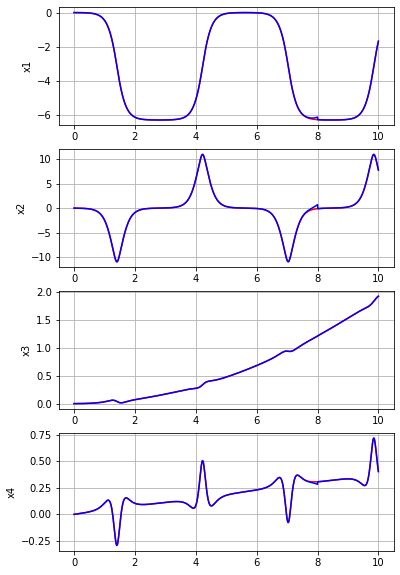

In [35]:
x_plot_real = np.array(x_list1)
tgrid = [delta_t * k for k in range(N + 1)]

x_plot_appr = np.array(x_list2)
tgrid = [delta_t * k for k in range(N + 1)]

plt.figure(1, figsize=(6, 10))
plt.clf()
for i in range (4):
    plt.subplot( str(4) + str(1) + str(i + 1) )
    plt.grid()
    x_opt_real = x_plot_real[:,i]
    x_opt_appr = x_plot_appr[:,i]
    plt.plot(tgrid, x_opt_real, 'r')
    plt.plot(tgrid, x_opt_appr, 'b')
    plt.ylabel('x' + str(i + 1))

### Test 3: Time-varying input

#### $\Delta_{sample} = 0.1 s$, $\Delta_{interval} = 1s$

In [36]:
N = 100

In [37]:
x_list1 = []
x_list1.append(x_init.flatten().tolist())

x_list2 = []
x_list2.append(x_init.flatten().tolist())

uk = np.array([[0.1]])
xk_real = x_init
xk_appr = x_init

N_delta = 10 # give accurate state every 1 second.
N = 100
for i in range(N):
    
    uk = np.sin(i * delta_t)
    if i == 0:
        x0 = x_init
        u0 = uk

    
    x_next_real = integrator_rk4(ode,xk_real,uk,delta_t)
    x_list1.append(x_next_real.full().flatten().tolist())

    
    if i % N_delta == 0:
        print(i)
        xk_appr = xk_real
        x0 = xk_appr
    
    x_next_appr = x_next_fn_lin(x0,xk_appr,u0,uk)
#     print(x_next)
    x_list2.append(x_next_appr.full().flatten().tolist())

    
    
    xk_real = x_next_real
    
    x0 = xk_appr
    xk_appr = x_next_appr

0
10
20
30
40
50
60
70
80
90


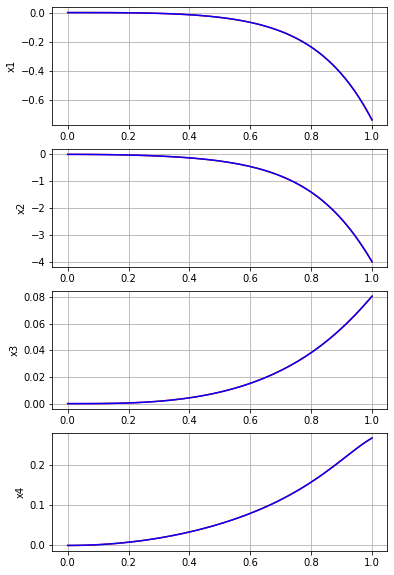

In [38]:
x_plot_real = np.array(x_list1)
tgrid = [delta_t * k for k in range(N + 1)]

x_plot_appr = np.array(x_list2)
tgrid = [delta_t * k for k in range(N + 1)]

plt.figure(1, figsize=(6, 10))
plt.clf()
for i in range (4):
    plt.subplot( str(4) + str(1) + str(i + 1) )
    plt.grid()
    x_opt_real = x_plot_real[:,i]
    x_opt_appr = x_plot_appr[:,i]
    plt.plot(tgrid, x_opt_real, 'r')
    plt.plot(tgrid, x_opt_appr, 'b')
    plt.ylabel('x' + str(i + 1))

#### without updating $x_0$ within $\Delta_{interval}$

$\Delta_{interval} = 1s$

In [39]:
x_list1 = []
x_list1.append(x_init.flatten().tolist())

x_list2 = []
x_list2.append(x_init.flatten().tolist())

uk = np.array([[0.1]])
xk_real = x_init
xk_appr = x_init

N_delta = 10 # give accurate state every 1 second.

for i in range(N):
#     if i == 0:
#         x0 = x_init
#         u0 = uk
    if i % N_delta == 0:
        print(i)
        xk_appr = xk_real
        x0 = xk_appr
        
    x_next_real = integrator_rk4(ode,xk_real,uk,delta_t)
    x_list1.append(x_next_real.full().flatten().tolist())

    

    
    x_next_appr = x_next_fn_lin(x0,xk_appr,u0,uk)
#     print(x_next)
    x_list2.append(x_next_appr.full().flatten().tolist())

    
    
    xk_real = x_next_real
    
#     x0 = xk_appr
    xk_appr = x_next_appr

0
10
20
30
40
50
60
70
80
90


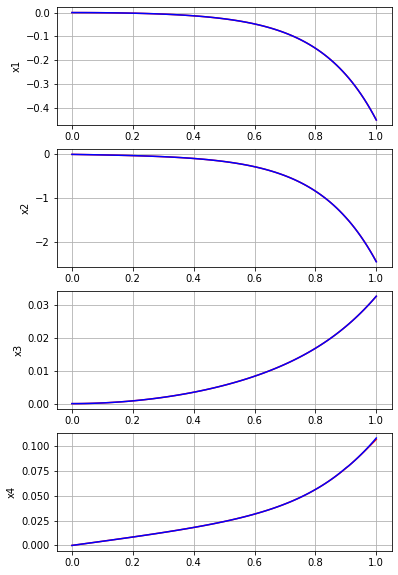

In [40]:
x_plot_real = np.array(x_list1)
tgrid = [delta_t * k for k in range(N + 1)]

x_plot_appr = np.array(x_list2)
tgrid = [delta_t * k for k in range(N + 1)]

plt.figure(1, figsize=(6, 10))
plt.clf()
for i in range (4):
    plt.subplot( str(4) + str(1) + str(i + 1) )
    plt.grid()
    x_opt_real = x_plot_real[:,i]
    x_opt_appr = x_plot_appr[:,i]
    plt.plot(tgrid, x_opt_real, 'r')
    plt.plot(tgrid, x_opt_appr, 'b')
    plt.ylabel('x' + str(i + 1))

$\Delta_{interval} = 0.5s$

In [41]:
x_list1 = []
x_list1.append(x_init.flatten().tolist())

x_list2 = []
x_list2.append(x_init.flatten().tolist())

uk = np.array([[0.1]])
xk_real = x_init
xk_appr = x_init

N_delta = 5 # give accurate state every 0.5 second.

for i in range(N):
#     if i == 0:
#         x0 = x_init
#         u0 = uk
    if i % N_delta == 0:
        print(i)
        xk_appr = xk_real
        x0 = xk_appr
        
    x_next_real = integrator_rk4(ode,xk_real,uk,delta_t)
    x_list1.append(x_next_real.full().flatten().tolist())

    

    
    x_next_appr = x_next_fn_lin(x0,xk_appr,u0,uk)
#     print(x_next)
    x_list2.append(x_next_appr.full().flatten().tolist())

    
    
    xk_real = x_next_real
    
#     x0 = xk_appr
    xk_appr = x_next_appr

0
5
10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90
95


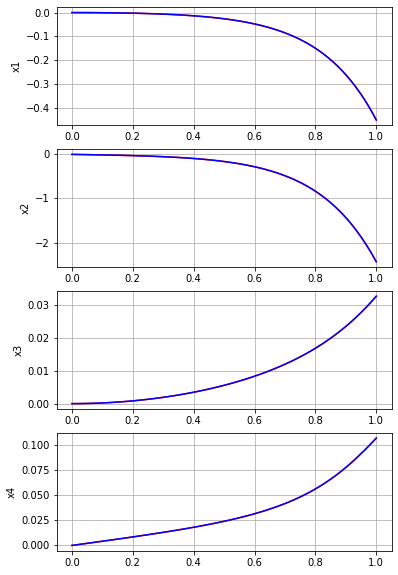

In [42]:
x_plot_real = np.array(x_list1)
tgrid = [delta_t * k for k in range(N + 1)]

x_plot_appr = np.array(x_list2)
tgrid = [delta_t * k for k in range(N + 1)]

plt.figure(1, figsize=(6, 10))
plt.clf()
for i in range (4):
    plt.subplot( str(4) + str(1) + str(i + 1) )
    plt.grid()
    x_opt_real = x_plot_real[:,i]
    x_opt_appr = x_plot_appr[:,i]
    plt.plot(tgrid, x_opt_real, 'r')
    plt.plot(tgrid, x_opt_appr, 'b')
    plt.ylabel('x' + str(i + 1))

### Test 4: MPC

#### $\Delta_{sample} = 0.1 s$

In [43]:
x_SX = ca.SX.sym("x_SX", 4)
u_SX = ca.SX.sym("u_SX", 1)

ode = ca.Function("ode_func", [x_SX, u_SX], [inverted_pendulum_nonlinear_ode(x_SX, u_SX)])
delta_t = 0.1

sys_int = integrator_rk4(ode, x_SX, u_SX, delta_t)
sys_int_fn = ca.Function("sys_int_fn",[x_SX, u_SX],[sys_int])

A = ca.jacobian(sys_int,x_SX)
B = ca.jacobian(sys_int,u_SX)

A_fn = ca.Function("A_fn",[x_SX,u_SX],[A])
B_fn = ca.Function("B_fn",[x_SX,u_SX],[B])

x0 =  ca.SX.sym("x0_SX", 4)
u0 = ca.SX.sym("u0_SX", 1)

xk =  ca.SX.sym("xk_SX", 4)
uk = ca.SX.sym("uk_SX", 1)


x_next = sys_int_fn(x0,u0) + A_fn(x0,u0) @(xk - x0) + B_fn(x0,u0) @ (uk - u0) 
x_next_fn_lin = ca.Function("x_next_fn_lin", [x0,xk,u0,uk],[x_next])

delta_fn = ca.Function("delta_fn", [x0,u0], [sys_int_fn(x0,u0) - A_fn(x0,u0) @  x0 - B_fn(x0,u0) @ u0] )

In [44]:
sys_int_fn(x0,u0)

SX(@1=0.0166667, @2=2, @3=0.05, @4=25.8003, @5=0.0828, @6=0.9468, @7=((((u0_SX*cos(x0_SX_0))-(@4*sin(x0_SX_0)))+(((@5*cos(x0_SX_0))*sin(x0_SX_0))*sq(x0_SX_1)))/((@5*sq(cos(x0_SX_0)))-@6)), @8=(x0_SX_1+(@3*@7)), @9=(x0_SX_0+(@3*x0_SX_1)), @10=((((u0_SX*cos(@9))-(@4*sin(@9)))+(((@5*cos(@9))*sin(@9))*sq(@8)))/((@5*sq(cos(@9)))-@6)), @11=(x0_SX_1+(@3*@10)), @12=0.1, @13=(x0_SX_0+(@3*@8)), @14=((((u0_SX*cos(@13))-(@4*sin(@13)))+(((@5*cos(@13))*sin(@13))*sq(@11)))/((@5*sq(cos(@13)))-@6)), @15=(x0_SX_1+(@12*@14)), @16=(x0_SX_0+(@12*@11)), @17=2.2563, @18=2.63, @19=0.23, @20=(((u0_SX+((@5*sin(x0_SX_0))*sq(x0_SX_1)))-((@17*cos(x0_SX_0))*sin(x0_SX_0)))/(@18-(@19*sq(cos(x0_SX_0))))), @21=(((u0_SX+((@5*sin(@9))*sq(@8)))-((@17*cos(@9))*sin(@9)))/(@18-(@19*sq(cos(@9))))), @22=(((u0_SX+((@5*sin(@13))*sq(@11)))-((@17*cos(@13))*sin(@13)))/(@18-(@19*sq(cos(@13))))), [(x0_SX_0+(@1*(((x0_SX_1+(@2*@8))+(@2*@11))+@15))), (x0_SX_1+(@1*(((@7+(@2*@10))+(@2*@14))+((((u0_SX*cos(@16))-(@4*sin(@16)))+(((@5*cos(@16

In [45]:
obj = 0

# state_prev_temp = np.zeros(np.shape(state_temp))
# A = (state_temp @ state_temp.T) * Theta_1  + (state_prev_temp @ state_prev_temp.T) * Theta_2 + Theta_3 * np.eye(np.shape(state_temp)[0])
# B = (state_temp @ Theta_4)

# nx = np.shape(A)[0]
# ny = 2
# nu = np.shape(B)[1]

N_pred = 20

xi_var = ca.SX.sym('x', 4, N_pred+1)
x0_para = ca.SX.sym('x0', 4, 1)
x_lin_para = ca.SX.sym('xlin', 4, 1)
# yr_para = ca.SX.sym('yr', 2, 1)
ui_var = ca.SX.sym('u', 1, N_pred)
u_lin_para = ca.SX.sym('ulin', 1, 1)

# A_para = ca.SX.sym('A_para', nx, nx)
# B_para = ca.SX.sym('B_para', nx, nu)

Q = 1000 * np.eye(4)
R = 1 * np.eye(1)
Qf = 10 * np.eye(4)

g = []

delta = delta_fn(x_lin_para,u_lin_para)
for i in range(N_pred):
#     obj += (C @ xi_var[:,i] - yr_para).T @ Q @ (C @ xi_var[:,i] - yr_para) + (ui_var[:,i]).T @ R @ (ui_var[:,i])
    obj +=  xi_var[:,i].T @ Q @  xi_var[:,i] + ui_var[:,i].T @ R @ ui_var[:,i]
    if i == 0:
        g += [xi_var[:,i] - x0_para]
    else:
        g += [xi_var[:,i] - (A_fn(x_lin_para,u_lin_para) @ xi_var[:,i-1] + B_fn(x_lin_para,u_lin_para) @ ui_var[:,i-1] + delta)]

obj += xi_var[:, -1].T @ Qf @ xi_var[:, -1]
g += [xi_var[:, -1] - (A_fn(x_lin_para,u_lin_para) @ xi_var[:, -2] + B_fn(x_lin_para,u_lin_para) @ ui_var[:,  -1] + delta)] # Terminal state        
dec_list = [ca.reshape(xi_var,-1,1), ca.reshape(ui_var,-1,1)]
para_list = [x0_para, x_lin_para, u_lin_para]
nlp_prob = {
    'f': obj,
    'x': ca.vertcat(*dec_list),
    'g': ca.vertcat(*g),
    'p': ca.vertcat(*para_list)
}
    

solver_opt = {}
solver_opt['print_time'] = False
solver_opt['ipopt'] = {
    'max_iter': 500,
    'print_level': 1,
    'acceptable_tol': 1e-6,
    'acceptable_obj_change_tol': 1e-6}


solver_appr = ca.nlpsol("solver", "ipopt", nlp_prob, solver_opt)  



#### Simulation

In [46]:
[xk, x_lin_para, u_lin_para]

[SX([xk_SX_0, xk_SX_1, xk_SX_2, xk_SX_3]),
 SX([xlin_0, xlin_1, xlin_2, xlin_3]),
 SX(ulin)]

In [47]:
lbg =  [0] * 4 * (N_pred + 1)
ubg =  [0] * 4 * (N_pred + 1)

nl = {}
nl['lbg'] = lbg
nl['ubg'] = ubg


x0 = np.array([[np.pi],[0],[0],[0]])
u0 = np.array([[0]])

x_appr_list = []

xk = x0
uk = u0


x_appr_list.append( xk.flatten().tolist())

In [48]:
u_ind = ca.reshape(xi_var,-1,1).shape[0]

In [49]:

# Simulation for 20 seconds
N_sim = 200
for i in range(N_sim):
    if i == 0:
        x_lin = x0
        u_lin = u0
    
    p = np.vstack([xk, x_lin, u_lin])
    nl['p'] = p
    
    sol = solver_appr(**nl)
    uk = sol['x'].full()[u_ind,0]
    x_next = integrator_rk4(ode,xk,uk,delta_t)
    
    x_appr_list.append(x_next.full().flatten().tolist())
    
    x_lin = xk
    xk = x_next



******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************



#### Real system

In [50]:
obj = 0

# state_prev_temp = np.zeros(np.shape(state_temp))
# A = (state_temp @ state_temp.T) * Theta_1  + (state_prev_temp @ state_prev_temp.T) * Theta_2 + Theta_3 * np.eye(np.shape(state_temp)[0])
# B = (state_temp @ Theta_4)

# nx = np.shape(A)[0]
# ny = 2
# nu = np.shape(B)[1]



N_pred = 20

xi_var = ca.SX.sym('x', 4, N_pred+1)
x0_para = ca.SX.sym('x0', 4, 1)
x_lin_para = ca.SX.sym('xlin', 4, 1)
# yr_para = ca.SX.sym('yr', 2, 1)
ui_var = ca.SX.sym('u', 1, N_pred)
u_lin_para = ca.SX.sym('ulin', 1, 1)

# A_para = ca.SX.sym('A_para', nx, nx)
# B_para = ca.SX.sym('B_para', nx, nu)

Q = 1000 * np.eye(4)
R = 1 * np.eye(1)
Qf = 10 * np.eye(4)

g = []


for i in range(N_pred):
#     obj += (C @ xi_var[:,i] - yr_para).T @ Q @ (C @ xi_var[:,i] - yr_para) + (ui_var[:,i]).T @ R @ (ui_var[:,i])
    obj +=  xi_var[:,i].T @ Q @  xi_var[:,i] + ui_var[:,i].T @ R @ ui_var[:,i]
    if i == 0:
        g += [xi_var[:,i] - x0_para]
    else:
        g += [xi_var[:,i] - integrator_rk4(ode, xi_var[:,i-1], ui_var[:,i-1], delta_t)]

obj += xi_var[:, -1].T @ Qf @ xi_var[:, -1]
g += [xi_var[:, -1] - integrator_rk4(ode, xi_var[:,-2], ui_var[:,-1], delta_t)] # Terminal state        
dec_list = [ca.reshape(xi_var,-1,1), ca.reshape(ui_var,-1,1)]
para_list = [x0_para]
nlp_prob = {
    'f': obj,
    'x': ca.vertcat(*dec_list),
    'g': ca.vertcat(*g),
    'p': ca.vertcat(*para_list)
}
    

solver_opt = {}
solver_opt['print_time'] = False
solver_opt['ipopt'] = {
    'max_iter': 500,
    'print_level': 1,
    'acceptable_tol': 1e-6,
    'acceptable_obj_change_tol': 1e-6}


solver_real = ca.nlpsol("solver", "ipopt", nlp_prob, solver_opt)  



In [51]:
lbg =  [0] * 4 * (N_pred + 1)
ubg =  [0] * 4 * (N_pred + 1)

nl = {}
nl['lbg'] = lbg
nl['ubg'] = ubg


x0 = np.array([[np.pi],[0],[0],[0]])
u0 = np.array([[0]])

x_real_list = []

xk = x0
uk = u0


x_real_list.append(xk.flatten().tolist())

In [52]:
u_ind = ca.reshape(xi_var,-1,1).shape[0]

In [53]:

# Simulation for 20 seconds
N_sim = 200
for i in range(N_sim):
    p = np.vstack([xk])
    nl['p'] = p
    
    sol = solver_real(**nl)
    uk = sol['x'].full()[u_ind,0]
    x_next = integrator_rk4(ode,xk,uk,delta_t)
    
    x_real_list.append(x_next.full().flatten().tolist())
    
    x_lin = xk
    xk = x_next


CasADi - 2021-10-13 09:46:24 WARNING("solver:nlp_g failed: Inf detected for output g, at (row 9, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2021-10-13 09:46:24 WARNING("solver:nlp_g failed: Inf detected for output g, at (row 9, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2021-10-13 09:46:24 WARNING("solver:nlp_g failed: Inf detected for output g, at (row 5, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2021-10-13 09:46:24 WARNING("solver:nlp_g failed: Inf detected for output g, at (row 5, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2021-10-13 09:46:24 WARNING("solver:nlp_g failed: Inf detected for output g, at (row 5, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2021-10-13 09:46:24 WARNING("solver:nlp_g failed: Inf detected for output g, at (row 9, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2021-10-13 09:46:25 WARNING("solver:nlp_g failed: Inf detected for output g, at (row 4, col 0).")

Sorry, things failed ?!?!


2021-10-13 09:46:27 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2021-10-13 09:46:27 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2021-10-13 09:46:27 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2021-10-13 09:46:27 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2021-10-13 09:46:27 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2021-10-13 09:46:27 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2021-10-13 09:46:27 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 0, col 0).") [.../cas

In [54]:
x_real_list

[[3.141592653589793, 0.0, 0.0, 0.0],
 [44.730380059853985,
  559.4943928625253,
  17.997338691786112,
  936.9279970927826],
 [54.43191574720512,
  -449.57465456547664,
  112.40634883145432,
  670.2640430164099],
 [-57.69476289382073,
  -1559.0001376843393,
  -13.346408276045196,
  -2908.3304038100296],
 [-2615.8537391006153,
  -5201626.139106144,
  -1319.3408556279699,
  -16841794.606140934],
 [7.16338142860874e+32,
  -8.038690151743654e+65,
  -5.7738230600260345e+32,
  -9.289580321835041e+65],
 [-inf, nan, -inf, nan],
 [nan, nan, nan, nan],
 [nan, nan, nan, nan],
 [nan, nan, nan, nan],
 [nan, nan, nan, nan],
 [nan, nan, nan, nan],
 [nan, nan, nan, nan],
 [nan, nan, nan, nan],
 [nan, nan, nan, nan],
 [nan, nan, nan, nan],
 [nan, nan, nan, nan],
 [nan, nan, nan, nan],
 [nan, nan, nan, nan],
 [nan, nan, nan, nan],
 [nan, nan, nan, nan],
 [nan, nan, nan, nan],
 [nan, nan, nan, nan],
 [nan, nan, nan, nan],
 [nan, nan, nan, nan],
 [nan, nan, nan, nan],
 [nan, nan, nan, nan],
 [nan, nan, nan

In [55]:
x_plot_appr

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [-5.78847712e-06, -1.15798344e-03,  2.08337867e-06,
         4.16684802e-04],
       [-2.31711966e-05, -2.31942565e-03,  8.33405896e-06,
         8.33478496e-04],
       [-5.22000786e-05, -3.48779572e-03,  1.87536755e-05,
         1.25049030e-03],
       [-9.29618293e-05, -4.66658345e-03,  3.33449580e-05,
         1.66783008e-03],
       [-1.45578199e-04, -5.85930974e-03,  5.21117395e-05,
         2.08560869e-03],
       [-2.10206348e-04, -7.06953710e-03,  7.50589679e-05,
         2.50393827e-03],
       [-2.87039312e-04, -8.30088038e-03,  1.02192720e-04,
         2.92293265e-03],
       [-3.76306582e-04, -9.55701747e-03,  1.33520222e-04,
         3.34270761e-03],
       [-4.78274791e-04, -1.08417003e-02,  1.69049868e-04,
         3.76338126e-03],
       [-5.93248506e-04, -1.21587661e-02,  2.08791245e-04,
         4.18507443e-03],
       [-7.21571129e-04, -1.35121479e-02,  2.52755165e-04,
      

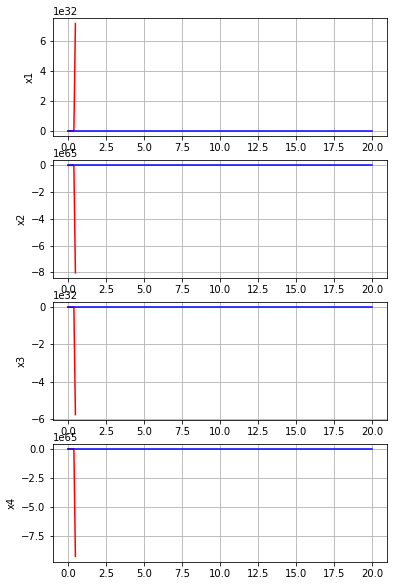

In [56]:
x_plot_real = np.array(x_real_list)
tgrid = [delta_t * k for k in range(N_sim + 1)]

x_plot_appr = np.array(x_appr_list)
tgrid = [delta_t * k for k in range(N_sim + 1)]

plt.figure(1, figsize=(6, 10))
plt.clf()
for i in range (4):
    plt.subplot( str(4) + str(1) + str(i + 1) )
    plt.grid()
    x_opt_real = x_plot_real[:,i]
    x_opt_appr = x_plot_appr[:,i]
    plt.plot(tgrid, x_opt_real, 'r')
    plt.plot(tgrid, x_opt_appr, 'b')
    plt.ylabel('x' + str(i + 1))

In [57]:
x_plot_appr

array([[ 3.14159265e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 3.14483488e+00,  6.31896510e-02,  1.19438400e-03,
         2.38355709e-02],
       [ 3.15000530e+00,  3.77343648e-02,  3.41981355e-03,
         2.05948127e-02],
       [ 3.15261353e+00,  1.31913388e-02,  5.52595640e-03,
         2.14890513e-02],
       [ 3.15304233e+00, -4.80175034e-03,  7.90957566e-03,
         2.61774611e-02],
       [ 3.15194652e+00, -1.65669006e-02,  1.08540966e-02,
         3.27301937e-02],
       [ 3.14991499e+00, -2.30673930e-02,  1.44691177e-02,
         3.96015941e-02],
       [ 3.14743064e+00, -2.54079520e-02,  1.87333874e-02,
         4.57219424e-02],
       [ 3.14486337e+00, -2.46893260e-02,  2.35395805e-02,
         5.04412174e-02],
       [ 3.14247492e+00, -2.19210921e-02,  2.87323807e-02,
         5.34512655e-02],
       [ 3.14043093e+00, -1.79689613e-02,  3.41385934e-02,
         5.47041459e-02],
       [ 3.13881702e+00, -1.35294511e-02,  3.95893057e-02,
      

### New linearization approach: linearize at the current state

In [58]:
x_SX = ca.SX.sym("x_SX", 4)
u_SX = ca.SX.sym("u_SX", 1)

ode = ca.Function("ode_func", [x_SX, u_SX], [inverted_pendulum_nonlinear_ode(x_SX, u_SX)])
delta_t = 0.1
# N = 5

In [59]:
sys_int = integrator_rk4(ode, x_SX, u_SX, delta_t)
sys_int_fn = ca.Function("sys_int_fn",[x_SX, u_SX],[sys_int])
A = ca.jacobian(sys_int,x_SX)
B = ca.jacobian(sys_int,u_SX)

A_fn = ca.Function("A_fn",[x_SX,u_SX],[A])
B_fn = ca.Function("B_fn",[x_SX,u_SX],[B])

x0 =  ca.SX.sym("x0_SX", 4)
u0 = ca.SX.sym("u0_SX", 1)

xk =  ca.SX.sym("xk_SX", 4)
uk = ca.SX.sym("uk_SX", 1)


x_next = sys_int_fn(x0,u0) + A_fn(x0,u0) @(xk - x0) + B_fn(x0,u0) @ (uk - u0)
x_next_fn_lin = ca.Function("x_next_fn_lin", [x0,xk,u0,uk],[x_next])

In [60]:
N = 100

x_init = np.array([[0],[0],[0],[0]])


x_next = A_fn(x0,u0) @ xk +  B_fn(x0,u0) @ uk
x_next_fn = ca.Function("x_next_fn",[x0,xk,u0,uk],[x_next])

x_list1 = []
x_list1.append(x_init.flatten().tolist())

uk = np.array([[0.1]])
xk = x_init

for i in range(N):
    if i == 0:
        u0 = uk

    x_next = x_next_fn_lin(xk,xk,u0,uk)
#     x_next = x_next_fn_lin(x0,xk,u0,uk)
#     print(x_next)
    x_list1.append(x_next.full().flatten().tolist())
    x0 = xk
    xk = x_next

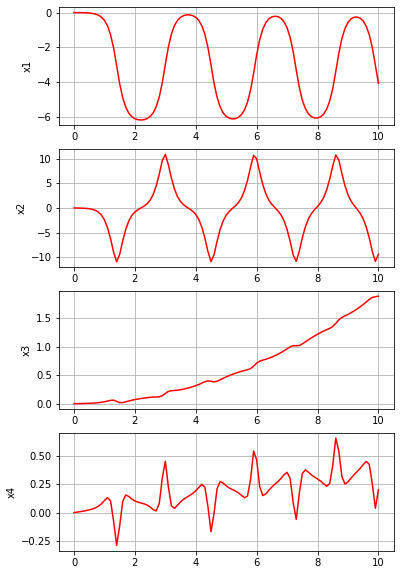

In [61]:
    
x_plot = np.array(x_list1)
tgrid = [delta_t * k for k in range(N + 1)]

plt.figure(1, figsize=(6, 10))
plt.clf()
for i in range (4):
    plt.subplot( str(4) + str(1) + str(i + 1) )
    plt.grid()
    x_opt = x_plot[:,i]
    plt.plot(tgrid, x_opt, 'r')
    plt.ylabel('x' + str(i + 1))

#### $\Delta_{sample} = 0.1 s$, $\Delta_{interval} = 1s$

In [62]:
x_list1 = []
x_list1.append(x_init.flatten().tolist())

x_list2 = []
x_list2.append(x_init.flatten().tolist())

uk = np.array([[0.1]])
xk_real = x_init
xk_appr = x_init

N_delta = 10 # give accurate state every 1 second.
N = 100
for i in range(N):
    
    uk = np.sin(i * delta_t)
    if i == 0:
        x0 = x_init
        u0 = uk

    
    x_next_real = integrator_rk4(ode,xk_real,uk,delta_t)
    x_list1.append(x_next_real.full().flatten().tolist())

    
    if i % N_delta == 0:
        print(i)
        xk_appr = xk_real
        x0 = xk_appr
    
    x_next_appr = x_next_fn_lin(x0,xk_appr,u0,uk)
#     print(x_next)
    x_list2.append(x_next_appr.full().flatten().tolist())

    
    
    xk_real = x_next_real
    
    x0 = xk_appr
    xk_appr = x_next_appr

0
10
20
30
40
50
60
70
80
90


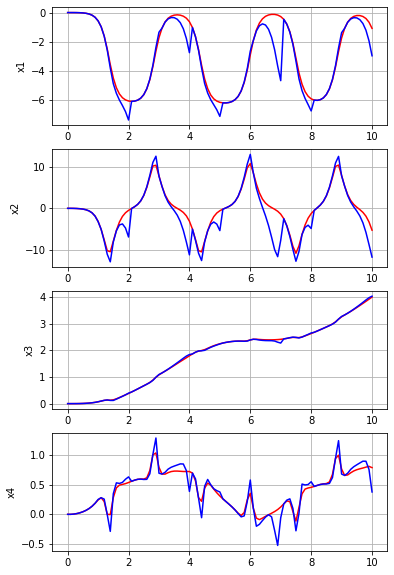

In [63]:
x_plot_real = np.array(x_list1)
tgrid = [delta_t * k for k in range(N + 1)]

x_plot_appr = np.array(x_list2)
tgrid = [delta_t * k for k in range(N + 1)]

plt.figure(1, figsize=(6, 10))
plt.clf()
for i in range (4):
    plt.subplot( str(4) + str(1) + str(i + 1) )
    plt.grid()
    x_opt_real = x_plot_real[:,i]
    x_opt_appr = x_plot_appr[:,i]
    plt.plot(tgrid, x_opt_real, 'r')
    plt.plot(tgrid, x_opt_appr, 'b')
    plt.ylabel('x' + str(i + 1))

### Test: MPC

#### $\Delta_{sample} = 0.1 s$

In [199]:
terminal_state = ca.DM([[0],[0],[0],[0]])

In [225]:
obj = 0

# state_prev_temp = np.zeros(np.shape(state_temp))
# A = (state_temp @ state_temp.T) * Theta_1  + (state_prev_temp @ state_prev_temp.T) * Theta_2 + Theta_3 * np.eye(np.shape(state_temp)[0])
# B = (state_temp @ Theta_4)

# nx = np.shape(A)[0]
# ny = 2
# nu = np.shape(B)[1]

N_pred = 5

xi_var = ca.SX.sym('x', 4, N_pred+1)
# xi_var = ca.SX.sym('x', 4, N_pred)
x0_para = ca.SX.sym('x0', 4, 1)
x_lin_para = ca.SX.sym('xlin', 4, 1)
# yr_para = ca.SX.sym('yr', 2, 1)
ui_var = ca.SX.sym('u', 1, N_pred)
u_lin_para = ca.SX.sym('ulin', 1, 1)

# A_para = ca.SX.sym('A_para', nx, nx)
# B_para = ca.SX.sym('B_para', nx, nu)

# Q = 100 * np.eye(4)
Q = np.diag([1500,1,1000,1])
R = 1 * np.eye(1)
# Qf = 10 * np.eye(4)
Qf = np.diag([1500,1,1000,1])
g = []

delta = delta_fn(x_lin_para,u_lin_para)
for i in range(N_pred):
#     obj += (C @ xi_var[:,i] - yr_para).T @ Q @ (C @ xi_var[:,i] - yr_para) + (ui_var[:,i]).T @ R @ (ui_var[:,i])
    obj +=  xi_var[:,i].T @ Q @  xi_var[:,i] + ui_var[:,i].T @ R @ ui_var[:,i]
    if i == 0:
        g += [xi_var[:,i] - x0_para]
    else:
        g += [xi_var[:,i] - (A_fn(x_lin_para,u_lin_para) @ xi_var[:,i-1] + B_fn(x_lin_para,u_lin_para) @ ui_var[:,i-1] + delta)]

obj += xi_var[:, -1].T @ Qf @ xi_var[:, -1]
g += [xi_var[:, -1] - (A_fn(x_lin_para,u_lin_para) @ xi_var[:, -2] + B_fn(x_lin_para,u_lin_para) @ ui_var[:,  -1] + delta)] # Terminal state        
# g += [terminal_state - (A_fn(x_lin_para,u_lin_para) @ xi_var[:, -2] + B_fn(x_lin_para,u_lin_para) @ ui_var[:,  -1] + delta)] # Terminal state        

# g += [xi_var[:, -1] - terminal_state]
dec_list = [ca.reshape(xi_var,-1,1), ca.reshape(ui_var,-1,1)]
para_list = [x0_para, x_lin_para, u_lin_para]
nlp_prob = {
    'f': obj,
    'x': ca.vertcat(*dec_list),
    'g': ca.vertcat(*g),
    'p': ca.vertcat(*para_list)
}
    

solver_opt = {}
solver_opt['print_time'] = False
solver_opt['ipopt'] = {
    'max_iter': 500,
    'print_level': 1,
    'acceptable_tol': 1e-6,
    'acceptable_obj_change_tol': 1e-6}


solver_appr = ca.nlpsol("solver", "ipopt", nlp_prob, solver_opt)  



Approximated system

In [226]:
N_sim = 200

In [227]:
lbg =  [0] * 4 * (N_pred + 1)
ubg =  [0] * 4 * (N_pred + 1)

lbx = [-ca.inf] * 4 * (N_pred+1) + [-ca.inf] * (N_pred)
# ubx = [ca.inf,ca.inf,ca.inf,0.5] * (N_pred+1) + [ca.inf] * (N_pred)
# ubx = [ca.inf,ca.inf,ca.inf,ca.inf] * (N_pred+1) + [ca.inf] * (N_pred)
ubx = [ca.inf,0.65,ca.inf,ca.inf] * (N_pred+1) + [ca.inf] * (N_pred)

nl = {}
nl['lbg'] = lbg
nl['ubg'] = ubg
nl['lbx'] = lbx
nl['ubx'] = ubx

# x1_start = np.pi/2
x1_start = -0.7

x0 = np.array([[x1_start],[0],[0],[0]])
u0 = np.array([[-20]])

x_appr_list = []
x_appr_pred_list = []
xk = x0
uk = u0

# nl['x0'] = [0, 0, 0, 0] * (N_pred+1) + [0] * N_pred

x_appr_list.append( xk.flatten().tolist())

u_ind = ca.reshape(xi_var,-1,1).shape[0]


# Simulation for 20 seconds

for i in range(N_sim):
    x_lin = xk
    u_lin = uk
    
#     if i >= 75: # only for some settings
#         lbx = [-ca.inf] * 4 * (N_pred+1) + [-ca.inf] * (N_pred)
#         ubx = [ca.inf,ca.inf,ca.inf,ca.inf] * (N_pred+1) + [ca.inf] * (N_pred)
#         nl['lbx'] = lbx
#         nl['ubx'] = ubx
    
    p = np.vstack([xk, x_lin, u_lin])
    nl['p'] = p
    
    sol = solver_appr(**nl)
#     print("state",sol['x'].full()[:u_ind])
    x_appr_pred_list += [sol['x'].full()[:u_ind]]
#     if i == 75: # plot
        
#     print("input",sol['x'].full()[u_ind:])
    uk = sol['x'].full()[u_ind,0]
#     if i == 0:
#         uk = -3
    x_next = integrator_rk4(ode,xk,uk,delta_t)
    
    x_appr_list.append(x_next.full().flatten().tolist())
    
    xk = x_next

In [228]:
print(x_appr_list)

[[-0.7, 0.0, 0.0, 0.0], [-0.6681228073185221, 0.6601037508068263, -0.05582627050298029, -1.117296706435873], [-0.6034450410523489, 0.6735184069617245, -0.2040081590627786, -1.8473503110937453], [-0.537784117159493, 0.6786744535584412, -0.42028269542685825, -2.479160832782992], [-0.47157859076979736, 0.683367999421067, -0.6953370860376039, -3.0229588333731723], [-0.40477743206331745, 0.6898064067020975, -1.020690937863126, -3.485163646635101], [-0.3373248985899455, 0.6958213839716161, -1.3883541606061724, -3.869158951851578], [-0.26920869454644764, 0.7026882491938505, -1.7906948417279545, -4.178725986171368], [-0.20051835531242235, 0.7070122977670518, -2.220329226174742, -4.415042989303368], [-0.13188068877581433, 0.7011665983093105, -2.669895759231699, -4.577367581023672], [-0.0640555072284928, 0.6900846536785703, -3.1321923649794026, -4.669633737502286], [0.002940381014764945, 0.6840427988997919, -3.600488649310983, -4.697350668044853], [0.06967365332091514, 0.6846996267646638, -4.068

Real system

In [229]:
obj = 0

# state_prev_temp = np.zeros(np.shape(state_temp))
# A = (state_temp @ state_temp.T) * Theta_1  + (state_prev_temp @ state_prev_temp.T) * Theta_2 + Theta_3 * np.eye(np.shape(state_temp)[0])
# B = (state_temp @ Theta_4)

# nx = np.shape(A)[0]
# ny = 2
# nu = np.shape(B)[1]



N_pred = 10

# xi_var = ca.SX.sym('x', 4, N_pred+1)
xi_var = ca.SX.sym('x', 4, N_pred+1)
x0_para = ca.SX.sym('x0', 4, 1)
x_lin_para = ca.SX.sym('xlin', 4, 1)
# yr_para = ca.SX.sym('yr', 2, 1)
ui_var = ca.SX.sym('u', 1, N_pred)
u_lin_para = ca.SX.sym('ulin', 1, 1)

# A_para = ca.SX.sym('A_para', nx, nx)
# B_para = ca.SX.sym('B_para', nx, nu)

Q = 10 * np.eye(4)
# Q = np.diag([10,1,5,1])
R = 1 * np.eye(1)
Qf = 10 * np.eye(4)
# Qf = np.diag([10,1,5,1])
g = []


for i in range(N_pred):
#     obj += (C @ xi_var[:,i] - yr_para).T @ Q @ (C @ xi_var[:,i] - yr_para) + (ui_var[:,i]).T @ R @ (ui_var[:,i])
    obj +=  xi_var[:,i].T @ Q @  xi_var[:,i] + ui_var[:,i].T @ R @ ui_var[:,i]
    if i == 0:
        g += [xi_var[:,i] - x0_para]
    else:
        g += [xi_var[:,i] - integrator_rk4(ode, xi_var[:,i-1], ui_var[:,i-1], delta_t)]

obj += xi_var[:, -1].T @ Qf @ xi_var[:, -1]
g += [xi_var[:, -1] - integrator_rk4(ode, xi_var[:,-2], ui_var[:,-1], delta_t)] # Terminal state        
# g += [terminal_state - integrator_rk4(ode, xi_var[:,-2], ui_var[:,-1], delta_t)] # Terminal state         
dec_list = [ca.reshape(xi_var,-1,1), ca.reshape(ui_var,-1,1)]
para_list = [x0_para]
nlp_prob = {
    'f': obj,
    'x': ca.vertcat(*dec_list),
    'g': ca.vertcat(*g),
    'p': ca.vertcat(*para_list)
}
    

solver_opt = {}
solver_opt['print_time'] = False
solver_opt['ipopt'] = {
    'max_iter': 500,
    'print_level': 1,
    'acceptable_tol': 1e-6,
    'acceptable_obj_change_tol': 1e-6}


solver_real = ca.nlpsol("solver", "ipopt", nlp_prob, solver_opt)  



lbg =  [0] * 4 * (N_pred + 1)
ubg =  [0] * 4 * (N_pred + 1)
lbx = [-ca.inf] * 4 * (N_pred+1) + [-ca.inf] * (N_pred)
ubx = [ca.inf,0.65,ca.inf,ca.inf] * (N_pred+1) + [ca.inf] * (N_pred)
nl = {}
nl['lbg'] = lbg
nl['ubg'] = ubg
nl['lbx'] = lbx
nl['ubx'] = ubx

In [230]:
x0 = np.array([[x1_start],[0],[0],[0]])
u0 = np.array([[0]])

x_real_list = []
x_real_pred_list = []
xk = x0
uk = u0


x_real_list.append(xk.flatten().tolist())

u_ind = ca.reshape(xi_var,-1,1).shape[0]

In [231]:
# Simulation for 20 seconds
for i in range(N_sim):
    p = np.vstack([xk])
    nl['p'] = p
    
    sol = solver_real(**nl)
    uk = sol['x'].full()[u_ind,0]
    
    x_real_pred_list += [sol['x'].full()[:u_ind]]
    
    x_next = integrator_rk4(ode,xk,uk,delta_t)
    
    x_real_list.append(x_next.full().flatten().tolist())

    x_lin = xk
    xk = x_next

Plot all prediction for the linearized MPC

In [232]:
np.array(x_pred_list[0])


array([[-0.7       ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [-0.668372  ],
       [ 0.65      ],
       [-0.0558051 ],
       [-1.116399  ],
       [-0.60532721],
       [ 0.65      ],
       [-0.20360156],
       [-1.84034237],
       [-0.54229178],
       [ 0.65      ],
       [-0.41868143],
       [-2.46206503],
       [-0.50417149],
       [ 0.13800314],
       [-0.67941518],
       [-2.75317024],
       [-0.54122019],
       [-0.89835569],
       [-0.95653445],
       [-2.78886563]])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:30: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:30: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:30: MatplotlibDeprecationWarning: Ad

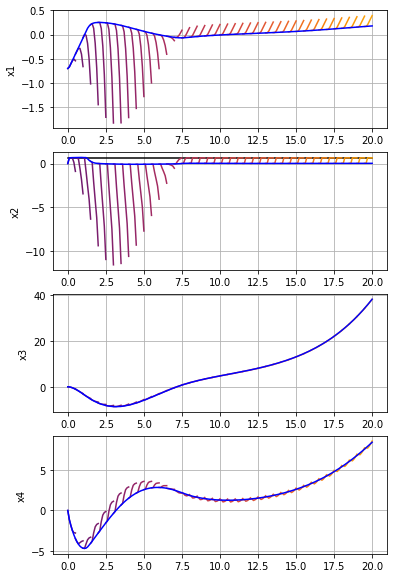

In [237]:
import matplotlib.pylab as pl
x_plot_appr = np.array(x_appr_list)
tgrid = [delta_t * k for k in range(N_sim + 1)]

plt.figure(1, figsize=(6, 10))
N_pred = 5

plt.figure(1, figsize=(6, 10))
plt.clf()


colors = pl.cm.inferno(np.linspace(0.3,0.8,N_sim + 1 - N_pred))
for i in range (4):
    plt.subplot( str(4) + str(1) + str(i + 1) )
    plt.grid()
    x_opt_real = x_plot_real[:,i]
    x_opt_appr = x_plot_appr[:,i]
    
    if i == 1:
        constr_plot_temp = [0.65] * (N_sim + 1)
        plt.plot(tgrid, constr_plot_temp, color="k")
    
    plt.plot(tgrid, x_opt_appr, 'b',zorder = 10)
    plt.ylabel('x' + str(i + 1))
for t in range(N_sim + 1 - N_pred):
    if t % 5 ==0:
        tgrid = [t * delta_t + delta_t * k for k in range(N_pred + 1)]
        x_plot_appr = np.array(x_appr_pred_list[t])
        for i in range(4):
            plt.subplot( str(4) + str(1) + str(i + 1) )
            x_opt_appr = x_plot_appr[i::4,:]
            plt.plot(tgrid, x_opt_appr, color=colors[t])


In [238]:
x_real_pred_list[0].shape

(44, 1)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:29: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:29: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:29: MatplotlibDeprecationWarning: Ad

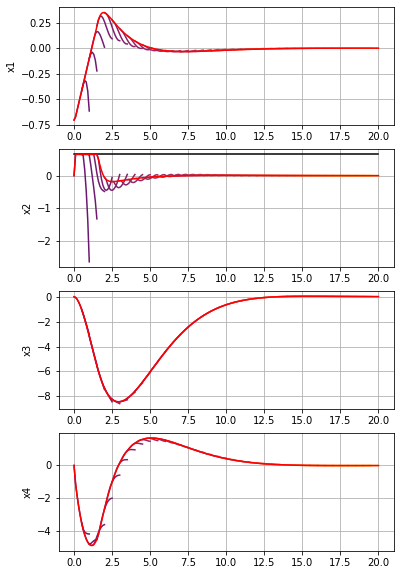

In [239]:
import matplotlib.pylab as pl
x_plot_real = np.array(x_real_list)
tgrid = [delta_t * k for k in range(N_sim + 1)]

plt.figure(1, figsize=(6, 10))
N_pred = 10

plt.figure(1, figsize=(6, 10))
plt.clf()


colors = pl.cm.inferno(np.linspace(0.3,0.8,N_sim + 1 - N_pred))
for i in range (4):
    plt.subplot( str(4) + str(1) + str(i + 1) )
    plt.grid()
    x_opt_real = x_plot_real[:,i]
    
    if i == 1:
        constr_plot_temp = [0.65] * (N_sim + 1)
        plt.plot(tgrid, constr_plot_temp, color="k")
    
    plt.plot(tgrid, x_opt_real, 'r',zorder = 10)
    plt.ylabel('x' + str(i + 1))
for t in range(N_sim + 1 - N_pred):
    if t % 5 ==0:
        tgrid = [t * delta_t + delta_t * k for k in range(N_pred + 1)]
        x_plot_real = np.array(x_real_pred_list[t])
        for i in range(4):
            plt.subplot( str(4) + str(1) + str(i + 1) )
            x_opt_real = x_plot_real[i::4,:]
            plt.plot(tgrid, x_opt_real, color=colors[t])


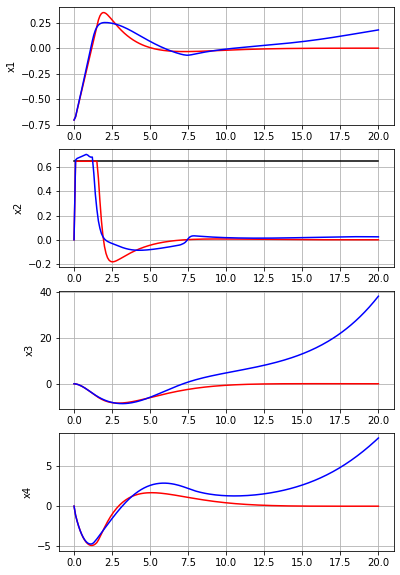

In [236]:
x_plot_real = np.array(x_real_list)
tgrid = [delta_t * k for k in range(N_sim + 1)]

x_plot_appr = np.array(x_appr_list)
tgrid = [delta_t * k for k in range(N_sim + 1)]

plt.figure(1, figsize=(6, 10))
plt.clf()
for i in range (4):
    plt.subplot( str(4) + str(1) + str(i + 1) )
    plt.grid()
    
    if i == 1:
        constr_plot_temp = [0.65] * (N_sim + 1)
        plt.plot(tgrid, constr_plot_temp, color="k")
    
    x_opt_real = x_plot_real[:,i]
    x_opt_appr = x_plot_appr[:,i]
    plt.plot(tgrid, x_opt_real, 'r')
    plt.plot(tgrid, x_opt_appr, 'b')
    plt.ylabel('x' + str(i + 1))

### CSTR example

Reference: https://reader.elsevier.com/reader/sd/pii/S1474667017313228?token=224BC5B42F541F7B66DCFCA4C355C5DAF8A9484522CE62C7723030A67751FA3B18D80FE8CF0D7ED3551E17EA1BA2D908&originRegion=eu-west-1&originCreation=20210815142702

$$
\begin{array}{ll}
q_{f} & 100 \\
C_{f} & 1 \\
T_{f} & 350 \\
T_{c} & 350 \\
E / R & 10000 \\
V & 100 \\
K_{0} & 7.2 \cdot 10^{10} \\
K_{1} & 1.44 \cdot 10^{13} \\
K_{2} & 0.01 \\
K_{3} & 700
\end{array}
$$

Mass balance:
$$
\frac{d T}{d t}= \frac{q_{f}}{V}\left(T_{f}-T\right)+K_{1} C e^{-\frac{E}{RT}} +K_{2} q_{c}\left(1-e^{-\frac{K_{3}}{q_c}}\right)\left(T_{c}-T\right)
$$
Energy balance:
$$
\frac{d C}{d t}=\frac{q_{f}}{V}\left(C_{f}-C\right)-K_{0} C e^{-\frac{E}{R T}}
$$

In [ ]:
def CSTR_nonlinear_ode(x, u):
    qf = 100
    Cf = 1
    Tf = 350
    Tc = 350
    E_R = 10000
    V = 100
    K0 = 7.2e10
    K1 = 1.44e13
    K2 = 0.01
    K3 = 700
    
    
    dx1_dt = qf/V * (Tf - x[0]) + K1 * x[1] * ca.exp(-E_R/x[0]) + K2 * u[0] * (1 - ca.exp(-K3/u[0])) * (Tc - x[0])
    dx2_dt = qf/V * (Cf - x[1]) - K0 * x[1] * ca.exp(-E_R/x[0])
    rhs = [dx1_dt,
           dx2_dt
           ]
    
    return ca.vertcat(*rhs)

In [ ]:
x_SX = ca.SX.sym("x_SX", 2)
u_SX = ca.SX.sym("u_SX", 1)

ode = ca.Function("ode_func", [x_SX, u_SX], [CSTR_nonlinear_ode(x_SX, u_SX)])
delta_t = 0.1
# N = 5

In [ ]:
sys_int = integrator_rk4(ode, x_SX, u_SX, delta_t)
sys_int_fn = ca.Function("sys_int_fn",[x_SX, u_SX],[sys_int])
A = ca.jacobian(sys_int,x_SX)
B = ca.jacobian(sys_int,u_SX)

A_fn = ca.Function("A_fn",[x_SX,u_SX],[A])
B_fn = ca.Function("B_fn",[x_SX,u_SX],[B])

x0 =  ca.SX.sym("x0_SX", 2)
u0 = ca.SX.sym("u0_SX", 1)

xk =  ca.SX.sym("xk_SX", 2)
uk = ca.SX.sym("uk_SX", 1)


x_next = sys_int_fn(x0,u0) + A_fn(x0,u0) @(xk - x0) + B_fn(x0,u0) @ (uk - u0)
x_next_fn_lin = ca.Function("x_next_fn_lin", [x0,xk,u0,uk],[x_next])

In [ ]:
N = 100

x_init = np.array([[432.94],[0.1298]])


x_next = A_fn(x0,u0) @ xk +  B_fn(x0,u0) @ uk
x_next_fn = ca.Function("x_next_fn",[x0,xk,u0,uk],[x_next])

In [ ]:
x_list1 = []
x_list1.append(x_init.flatten().tolist())

uk = np.array([[110]])
xk = x_init

for i in range(N):
    if i == 0:
        u0 = uk

    x_next = x_next_fn_lin(xk,xk,u0,uk)
#     x_next = x_next_fn_lin(x0,xk,u0,uk)
#     print(x_next)
    x_list1.append(x_next.full().flatten().tolist())
    x0 = xk
    xk = x_next

#### Openloop simulation

In [ ]:
x_plot = np.array(x_list1)
tgrid = [delta_t * k for k in range(N + 1)]

plt.figure(1, figsize=(6, 10))
plt.clf()
for i in range (2):
    plt.subplot( str(2) + str(1) + str(i + 1) )
    plt.grid()
    x_opt = x_plot[:,i]
    plt.plot(tgrid, x_opt, 'r')
    plt.ylabel('x' + str(i + 1))

In [ ]:
x_list1

In [ ]:
x_list1 = []
x_list1.append(x_init.flatten().tolist())

x_list2 = []
x_list2.append(x_init.flatten().tolist())

uk = np.array([[110]])
xk_real = x_init
xk_appr = x_init

N_delta = 10 # give accurate state every 1 second.
N = 100
for i in range(N):
    
#     uk = np.sin(i * delta_t)
    if i == 0:
        x0 = x_init
        u0 = uk

    
    x_next_real = integrator_rk4(ode,xk_real,uk,delta_t)
    x_list1.append(x_next_real.full().flatten().tolist())

    
    if i % N_delta == 0:
        print(i)
        xk_appr = xk_real
        x0 = xk_appr
    
    x_next_appr = x_next_fn_lin(x0,xk_appr,u0,uk)
#     print(x_next)
    x_list2.append(x_next_appr.full().flatten().tolist())

    
    
    xk_real = x_next_real
    
    x0 = xk_appr
    xk_appr = x_next_appr

In [ ]:
x_plot_real = np.array(x_list1)
tgrid = [delta_t * k for k in range(N + 1)]

x_plot_appr = np.array(x_list2)
tgrid = [delta_t * k for k in range(N + 1)]

plt.figure(1, figsize=(6, 10))
plt.clf()
for i in range (2):
    plt.subplot( str(2) + str(1) + str(i + 1) )
    plt.grid()
    x_opt_real = x_plot_real[:,i]
    x_opt_appr = x_plot_appr[:,i]
    plt.plot(tgrid, x_opt_real, 'r')
    plt.plot(tgrid, x_opt_appr, 'b')
    plt.ylabel('x' + str(i + 1))

#### step response

In [ ]:
x_list1 = []
x_list1.append(x_init.flatten().tolist())

uk = np.array([[110]])
xk = x_init

step_input_list = [110,105,98.9,88.3,68.8]
N_len = len(step_input_list)

N = 50
input_counter = 0
for i in range(N * N_len):
    if i % N == 0 and i != 0:
        input_counter += 1
    uk = step_input_list[input_counter]
    u0 = uk
    x_next = x_next_fn_lin(xk,xk,u0,uk)
#     x_next = x_next_fn_lin(x0,xk,u0,uk)
#     print(x_next)
    x_list1.append(x_next.full().flatten().tolist())
    x0 = xk
    xk = x_next

In [ ]:
x_plot = np.array(x_list1)
tgrid = [delta_t * k for k in range(N * N_len + 1)]

plt.figure(1, figsize=(6, 10))
plt.clf()
for i in range (2):
    plt.subplot( str(2) + str(1) + str(i + 1) )
    plt.grid()
    x_opt = x_plot[:,i]
    plt.plot(tgrid, x_opt, 'r')
    plt.ylabel('x' + str(i + 1))

In [ ]:
x_list1 = []
x_list1.append(x_init.flatten().tolist())

x_list2 = []
x_list2.append(x_init.flatten().tolist())

uk = np.array([[110]])
xk_real = x_init
xk_appr = x_init

N_delta = 10 # give accurate state every 1 second.
N = 50

step_input_list = [110,105,98.9,88.3,68.8]
N_len = len(step_input_list)
input_counter = 0
for i in range(N * N_len):
    if i % N == 0 and i != 0:
        input_counter += 1
    uk = step_input_list[input_counter]
    u0 = uk

    
    x_next_real = integrator_rk4(ode,xk_real,uk,delta_t)
    x_list1.append(x_next_real.full().flatten().tolist())

    
#     if i % N_delta == 0:
#         print(i)
#         xk_appr = xk_real
#         x0 = xk_appr
    
    x_next_appr = x_next_fn_lin(x0,xk_appr,u0,uk)
#     print(x_next)
    x_list2.append(x_next_appr.full().flatten().tolist())

    
    
    xk_real = x_next_real
    
    x0 = xk_appr
    xk_appr = x_next_appr

In [ ]:
x_plot_real = np.array(x_list1)
tgrid = [delta_t * k for k in range(N * N_len + 1)]

x_plot_appr = np.array(x_list2)
tgrid = [delta_t * k for k in range(N * N_len+ 1)]

plt.figure(1, figsize=(6, 10))
plt.clf()
for i in range (2):
    plt.subplot( str(2) + str(1) + str(i + 1) )
    plt.grid()
    x_opt_real = x_plot_real[:,i]
    x_opt_appr = x_plot_appr[:,i]
    plt.plot(tgrid, x_opt_real, 'r')
    plt.plot(tgrid, x_opt_appr, 'b')
    plt.ylabel('x' + str(i + 1))

### Test: MPC

In [ ]:
x_SX = ca.SX.sym("x_SX", 2)
u_SX = ca.SX.sym("u_SX", 1)

ode = ca.Function("ode_func", [x_SX, u_SX], [CSTR_nonlinear_ode(x_SX, u_SX)])
delta_t = 0.1

sys_int = integrator_rk4(ode, x_SX, u_SX, delta_t)
sys_int_fn = ca.Function("sys_int_fn",[x_SX, u_SX],[sys_int])

A = ca.jacobian(sys_int,x_SX)
B = ca.jacobian(sys_int,u_SX)

A_fn = ca.Function("A_fn",[x_SX,u_SX],[A])
B_fn = ca.Function("B_fn",[x_SX,u_SX],[B])

x0 =  ca.SX.sym("x0_SX", 2)
u0 = ca.SX.sym("u0_SX", 1)

xk =  ca.SX.sym("xk_SX", 2)
uk = ca.SX.sym("uk_SX", 1)


x_next = sys_int_fn(x0,u0) + A_fn(x0,u0) @(xk - x0) + B_fn(x0,u0) @ (uk - u0) 
x_next_fn_lin = ca.Function("x_next_fn_lin", [x0,xk,u0,uk],[x_next])

delta_fn = ca.Function("delta_fn", [x0,u0], [sys_int_fn(x0,u0) - A_fn(x0,u0) @  x0 - B_fn(x0,u0) @ u0] )

In [ ]:
obj = 0

# state_prev_temp = np.zeros(np.shape(state_temp))
# A = (state_temp @ state_temp.T) * Theta_1  + (state_prev_temp @ state_prev_temp.T) * Theta_2 + Theta_3 * np.eye(np.shape(state_temp)[0])
# B = (state_temp @ Theta_4)

# nx = np.shape(A)[0]
# ny = 2
# nu = np.shape(B)[1]

N_pred = 10

xi_var = ca.SX.sym('x', 2, N_pred+1)
# xi_var = ca.SX.sym('x', 4, N_pred)
x0_para = ca.SX.sym('x0', 2, 1)
x_lin_para = ca.SX.sym('xlin', 2, 1)
xr_para = ca.SX.sym('xr', 2, 1)
ui_var = ca.SX.sym('u', 1, N_pred)
u_lin_para = ca.SX.sym('ulin', 1, 1)
ur_para = ca.SX.sym('ur', 1, 1)
# A_para = ca.SX.sym('A_para', nx, nx)
# B_para = ca.SX.sym('B_para', nx, nu)

Q = 10 * np.eye(2)
R = 1 * np.eye(1)
Qf = 10 * np.eye(2)

g = []

delta = delta_fn(x_lin_para,u_lin_para)
for i in range(N_pred):
#     obj += (C @ xi_var[:,i] - yr_para).T @ Q @ (C @ xi_var[:,i] - yr_para) + (ui_var[:,i]).T @ R @ (ui_var[:,i])
#     obj += (C @ xi_var[:,i] - yr_para).T @ Q @ (C @ xi_var[:,i] - yr_para) + (ui_var[:,i]).T @ R @ (ui_var[:,i])
    obj +=  (xi_var[:,i] - xr_para).T @ Q @  (xi_var[:,i] - xr_para) + (ui_var[:,i] - ur_para).T @ R @ (ui_var[:,i] - ur_para)
    if i == 0:
        g += [xi_var[:,i] - x0_para]
    else:
        g += [xi_var[:,i] - (A_fn(x_lin_para,u_lin_para) @ xi_var[:,i-1] + B_fn(x_lin_para,u_lin_para) @ ui_var[:,i-1] + delta)]

obj += (xi_var[:, -1]- xr_para).T @ Qf @ (xi_var[:, -1]- xr_para)
g += [xi_var[:, -1] - (A_fn(x_lin_para,u_lin_para) @ xi_var[:, -2] + B_fn(x_lin_para,u_lin_para) @ ui_var[:,  -1] + delta)] # Terminal state        
# g += [terminal_state - (A_fn(x_lin_para,u_lin_para) @ xi_var[:, -2] + B_fn(x_lin_para,u_lin_para) @ ui_var[:,  -1] + delta)] # Terminal state        

# g += [xi_var[:, -1] - terminal_state]
dec_list = [ca.reshape(xi_var,-1,1), ca.reshape(ui_var,-1,1)]
para_list = [x0_para, x_lin_para, u_lin_para, xr_para,ur_para]
nlp_prob = {
    'f': obj,
    'x': ca.vertcat(*dec_list),
    'g': ca.vertcat(*g),
    'p': ca.vertcat(*para_list)
}
    

solver_opt = {}
solver_opt['print_time'] = False
solver_opt['ipopt'] = {
    'max_iter': 500,
    'print_level': 1,
    'acceptable_tol': 1e-6,
    'acceptable_obj_change_tol': 1e-6}


solver_appr = ca.nlpsol("solver", "ipopt", nlp_prob, solver_opt)  



In [ ]:
N_sim = 200

In [ ]:
lbg =  [0] * 2 * (N_pred + 1)
ubg =  [0] * 2 * (N_pred + 1)

nl = {}
nl['lbg'] = lbg
nl['ubg'] = ubg

# x1_start = np.pi/2
x1_start = 432.94
x2_start = 0.1298

x1r = 437.25
x2r = 0.1062

x0 = np.array([[x1_start],[x2_start]])
u0 = np.array([[110]])

xr = np.array([[x1r],[x2r]])
ur = np.array([[105]])
x_appr_list = []

xk = x0
uk = u0


x_appr_list.append( xk.flatten().tolist())

u_ind = ca.reshape(xi_var,-1,1).shape[0]


# Simulation for 20 seconds

for i in range(N_sim):
    x_lin = xk
    u_lin = uk
    
    p = np.vstack([xk, x_lin, u_lin,xr,ur])
    nl['p'] = p
    
    sol = solver_appr(**nl)
#     print("state",sol['x'].full()[:u_ind])
    print("input",sol['x'].full()[u_ind:])
    uk = sol['x'].full()[u_ind,0]
#     if i == 0:
#         uk = -3
    x_next = integrator_rk4(ode,xk,uk,delta_t)
    
    x_appr_list.append(x_next.full().flatten().tolist())
    
    xk = x_next

Real system

In [ ]:
obj = 0

# state_prev_temp = np.zeros(np.shape(state_temp))
# A = (state_temp @ state_temp.T) * Theta_1  + (state_prev_temp @ state_prev_temp.T) * Theta_2 + Theta_3 * np.eye(np.shape(state_temp)[0])
# B = (state_temp @ Theta_4)

# nx = np.shape(A)[0]
# ny = 2
# nu = np.shape(B)[1]



N_pred = 10

# xi_var = ca.SX.sym('x', 4, N_pred+1)
xi_var = ca.SX.sym('x', 2, N_pred+1)
x0_para = ca.SX.sym('x0', 2, 1)
xr_para = ca.SX.sym('xr', 2, 1)
ui_var = ca.SX.sym('u', 1, N_pred)
ur_para = ca.SX.sym('ur', 1, 1)



# A_para = ca.SX.sym('A_para', nx, nx)
# B_para = ca.SX.sym('B_para', nx, nu)

Q = 10 * np.eye(2)
R = 1 * np.eye(1)
Qf = 10 * np.eye(2)

g = []


for i in range(N_pred):
#     obj += (C @ xi_var[:,i] - yr_para).T @ Q @ (C @ xi_var[:,i] - yr_para) + (ui_var[:,i]).T @ R @ (ui_var[:,i])
    obj +=  (xi_var[:,i] - xr_para).T @ Q @  (xi_var[:,i] - xr_para) + (ui_var[:,i] - ur_para).T @ R @ (ui_var[:,i] - ur_para)
    if i == 0:
        g += [xi_var[:,i] - x0_para]
    else:
        g += [xi_var[:,i] - integrator_rk4(ode, xi_var[:,i-1], ui_var[:,i-1], delta_t)]

obj += (xi_var[:, -1]- xr_para).T @ Qf @ (xi_var[:, -1]- xr_para)
g += [xi_var[:, -1] - integrator_rk4(ode, xi_var[:,-2], ui_var[:,-1], delta_t)] # Terminal state        
# g += [terminal_state - integrator_rk4(ode, xi_var[:,-2], ui_var[:,-1], delta_t)] # Terminal state         
dec_list = [ca.reshape(xi_var,-1,1), ca.reshape(ui_var,-1,1)]
para_list = [x0_para,xr_para,ur_para]
nlp_prob = {
    'f': obj,
    'x': ca.vertcat(*dec_list),
    'g': ca.vertcat(*g),
    'p': ca.vertcat(*para_list)
}
    

solver_opt = {}
solver_opt['print_time'] = False
solver_opt['ipopt'] = {
    'max_iter': 500,
    'print_level': 1,
    'acceptable_tol': 1e-6,
    'acceptable_obj_change_tol': 1e-6}


solver_real = ca.nlpsol("solver", "ipopt", nlp_prob, solver_opt)

In [ ]:
xi_var.shape

In [ ]:
lbg =  [0] * 2 * (N_pred + 1)
ubg =  [0] * 2 * (N_pred + 1)

nl = {}
nl['lbg'] = lbg
nl['ubg'] = ubg

# x1_start = np.pi/2
x1_start = 432.94
x2_start = 0.1298

x1r = 437.25
x2r = 0.1062
u1r = 105
x0 = np.array([[x1_start],[x2_start]])

xr = np.array([[x1r],[x2r]])
ur = np.array([[u1r]])
x_real_list = []

xk = x0
uk = u0
x_real_list = []
x_real_list.append(xk.flatten().tolist())

u_ind = ca.reshape(xi_var,-1,1).shape[0]

In [ ]:
p = np.vstack([xk,xr,ur])
nl['p'] = p
x_guess = [x1r,x2r] * (N_pred+1) + [u1r] * N_pred
nl['x0'] = x_guess
sol = solver_real(**nl)

In [ ]:
# Simulation for 20 seconds
for i in range(N_sim):
    p = np.vstack([xk,xr,ur])
    nl['p'] = p
    
    sol = solver_real(**nl)
    uk = sol['x'].full()[u_ind,0]
    x_next = integrator_rk4(ode,xk,uk,delta_t)
    
    x_real_list.append(x_next.full().flatten().tolist())
    
    x_lin = xk
    xk = x_next

In [ ]:
x_plot_real = np.array(x_real_list)
tgrid = [delta_t * k for k in range(N_sim + 1)]

x_plot_appr = np.array(x_appr_list)
tgrid = [delta_t * k for k in range(N_sim + 1)]

plt.figure(1, figsize=(6, 10))
plt.clf()
for i in range (2):
    plt.subplot( str(2) + str(1) + str(i + 1) )
    plt.grid()
    x_opt_real = x_plot_real[:,i]
    x_opt_appr = x_plot_appr[:,i]
    plt.plot(tgrid, x_opt_real, 'r')
    plt.plot(tgrid, x_opt_appr, 'b')
    plt.ylabel('x' + str(i + 1))

In [ ]:
x_appr_list

Test: linearization around the set point

In [ ]:
lbg =  [0] * 2 * (N_pred + 1)
ubg =  [0] * 2 * (N_pred + 1)

nl = {}
nl['lbg'] = lbg
nl['ubg'] = ubg

# x1_start = np.pi/2
x1_start = 432.94
x2_start = 0.1298

x1r = 437.25
x2r = 0.1062

x0 = np.array([[x1_start],[x2_start]])
u0 = np.array([[110]])

xr = np.array([[x1r],[x2r]])
ur = np.array([[105]])
x_linear_list = []

xk = x0
uk = u0


x_linear_list.append( xk.flatten().tolist())

u_ind = ca.reshape(xi_var,-1,1).shape[0]


x_lin = xr
u_lin = ur

x_guess = [x1r,x2r] * (N_pred + 1) + [u1r] * N_pred
nl['x0'] = x_guess
for i in range(N_sim):

    
    p = np.vstack([xk, x_lin, u_lin,xr,ur])
    nl['p'] = p
    
    sol = solver_appr(**nl)
#     print("state",sol['x'].full()[:u_ind])
    print("input",sol['x'].full()[u_ind:])
    uk = sol['x'].full()[u_ind,0]
#     if i == 0:
#         uk = -3
    x_next = integrator_rk4(ode,xk,uk,delta_t)
    
    x_linear_list.append(x_next.full().flatten().tolist())
    
    xk = x_next

#### Remark:

Simulation result depends on the initial guess.

In [ ]:
x_plot_real = np.array(x_real_list)
tgrid = [delta_t * k for k in range(N_sim + 1)]

x_plot_linear = np.array(x_linear_list)
tgrid = [delta_t * k for k in range(N_sim + 1)]

x_plot_appr = np.array(x_appr_list)
tgrid = [delta_t * k for k in range(N_sim + 1)]

plt.figure(1, figsize=(6, 10))
plt.clf()
for i in range (2):
    plt.subplot( str(2) + str(1) + str(i + 1) )
    plt.grid()
    x_opt_real = x_plot_real[:,i]
    x_opt_linear = x_plot_linear[:,i]
    x_opt_appr = x_plot_appr[:,i]
    plt.plot(tgrid, x_opt_appr, 'orange')
    plt.plot(tgrid, x_opt_real, 'r')
    plt.plot(tgrid, x_opt_linear, 'b')
    plt.ylabel('x' + str(i + 1))

#### Test: Tracking MPC

In [ ]:
x_list1 = []
x_list1.append(x_init.flatten().tolist())

uk = np.array([[110]])
xk = x_init

ur_list = [110, 105, 98.9, 88.3, 68.6]
x1r_list = [432.94, 437.25, 442.07, 450.03, 465.00]
x2r_list = [0.1298, 0.1062, 0.0848, 0.0585, 0.0295]

x1_start = 420
x2_start = 0.1
u0 = np.array([[105]])


N = 50
N_len = len(step_input_list)


# for i in range(N * N_len):
#     if i % N == 0 and i != 0:
#         input_counter += 1
#     uk = step_input_list[input_counter]
#     u0 = uk
#     x_next = x_next_fn_lin(xk,xk,u0,uk)
# #     x_next = x_next_fn_lin(x0,xk,u0,uk)
# #     print(x_next)
#     x_list1.append(x_next.full().flatten().tolist())
#     x0 = xk
#     xk = x_next



### Appr
lbg =  [0] * 2 * (N_pred + 1)
ubg =  [0] * 2 * (N_pred + 1)

nl = {}
nl['lbg'] = lbg
nl['ubg'] = ubg

# x1_start = np.pi/2




x0 = np.array([[x1_start],[x2_start]])



x_appr_list = []

xk = x0
uk = u0


x_appr_list.append( xk.flatten().tolist())

u_ind = ca.reshape(xi_var,-1,1).shape[0]



input_counter = 0



for i in range(N * N_len):
    x_lin = xk
    u_lin = uk

    if i % N == 0 and i != 0:
        input_counter += 1

    xr = np.array([[x1r_list[input_counter]],[x2r_list[input_counter]]])
    ur = np.array([[ur_list[input_counter]]])   
    
    p = np.vstack([xk, x_lin, u_lin,xr,ur])
    nl['p'] = p
    
    sol = solver_appr(**nl)
#     print("state",sol['x'].full()[:u_ind])
    print("input",sol['x'].full()[u_ind:])
    uk = sol['x'].full()[u_ind,0]
#     if i == 0:
#         uk = -3
    x_next = integrator_rk4(ode,xk,uk,delta_t)
    
    x_appr_list.append(x_next.full().flatten().tolist())
    
    xk = x_next


### Real
lbg =  [0] * 2 * (N_pred + 1)
ubg =  [0] * 2 * (N_pred + 1)

nl = {}
nl['lbg'] = lbg
nl['ubg'] = ubg

x0 = np.array([[x1_start],[x2_start]])

xk = x0
uk = u0
x_real_list = []
x_real_list.append(xk.flatten().tolist())

input_counter = 0

for i in range(N * N_len):
    if i % N == 0 and i != 0:
        input_counter += 1

    xr = np.array([[x1r_list[input_counter]],[x2r_list[input_counter]]])
    ur = np.array([[ur_list[input_counter]]])  
    
    
    p = np.vstack([xk,xr,ur])
    nl['p'] = p
    
    x_guess = [x1r_list[input_counter],x2r_list[input_counter]] * (N_pred+1) + [ur_list[input_counter]] * N_pred
    nl['x0'] = x_guess

    sol = solver_real(**nl)
    uk = sol['x'].full()[u_ind,0]
    x_next = integrator_rk4(ode,xk,uk,delta_t)
    
    x_real_list.append(x_next.full().flatten().tolist())
    
    x_lin = xk
    xk = x_next
### Linear
lbg =  [0] * 2 * (N_pred + 1)
ubg =  [0] * 2 * (N_pred + 1)

nl = {}
nl['lbg'] = lbg
nl['ubg'] = ubg

# x1_start = np.pi/2

x0 = np.array([[x1_start],[x2_start]])

xk = x0
uk = u0


x_linear_list = []
x_linear_list.append( xk.flatten().tolist())

input_counter = 0

for i in range(N * N_len):
    if i % N == 0 and i != 0:
        input_counter += 1

    xr = np.array([[x1r_list[input_counter]],[x2r_list[input_counter]]])
    ur = np.array([[ur_list[input_counter]]])   
    x_lin = xr
    u_lin = ur    
    p = np.vstack([xk, x_lin, u_lin,xr,ur])
    nl['p'] = p

    x_guess = [x1r_list[input_counter],x2r_list[input_counter]] * (N_pred + 1) + [ur_list[input_counter]] * N_pred
    nl['x0'] = x_guess
    
    
    sol = solver_appr(**nl)
#     print("state",sol['x'].full()[:u_ind])
    print("input",sol['x'].full()[u_ind:])
    uk = sol['x'].full()[u_ind,0]

    x_next = integrator_rk4(ode,xk,uk,delta_t)
    
    x_linear_list.append(x_next.full().flatten().tolist())
    
    xk = x_next





In [ ]:
x_plot_real = np.array(x_real_list)
tgrid = [delta_t * k for k in range(N * N_len + 1)]

x_plot_linear = np.array(x_linear_list)
tgrid = [delta_t * k for k in range(N * N_len + 1)]

x_plot_appr = np.array(x_appr_list)
tgrid = [delta_t * k for k in range(N * N_len + 1)]

plt.figure(1, figsize=(6, 10))
plt.clf()
for i in range (2):
    plt.subplot( str(2) + str(1) + str(i + 1) )
    plt.grid()
    x_opt_real = x_plot_real[:,i]
    x_opt_linear = x_plot_linear[:,i]
    x_opt_appr = x_plot_appr[:,i]
    plt.plot(tgrid, x_opt_appr, 'k')
    plt.plot(tgrid, x_opt_real, 'r')
    plt.plot(tgrid, x_opt_linear, 'b')
    plt.ylabel('x' + str(i + 1))

#### Test: measurement noise

In [ ]:
x_list1 = []
x_list1.append(x_init.flatten().tolist())

uk = np.array([[110]])
xk = x_init

ur_list = [110, 105, 98.9, 88.3, 68.6]
x1r_list = [432.94, 437.25, 442.07, 450.03, 465.00]
x2r_list = [0.1298, 0.1062, 0.0848, 0.0585, 0.0295]

x1_start = 420
x2_start = 0.1
u0 = np.array([[105]])


N = 50
N_len = len(step_input_list)


# for i in range(N * N_len):
#     if i % N == 0 and i != 0:
#         input_counter += 1
#     uk = step_input_list[input_counter]
#     u0 = uk
#     x_next = x_next_fn_lin(xk,xk,u0,uk)
# #     x_next = x_next_fn_lin(x0,xk,u0,uk)
# #     print(x_next)
#     x_list1.append(x_next.full().flatten().tolist())
#     x0 = xk
#     xk = x_next



### Appr
lbg =  [0] * 2 * (N_pred + 1)
ubg =  [0] * 2 * (N_pred + 1)

nl = {}
nl['lbg'] = lbg
nl['ubg'] = ubg

# x1_start = np.pi/2




x0 = np.array([[x1_start],[x2_start]])



x_appr_list = []

xk = x0
uk = u0


x_appr_list.append( xk.flatten().tolist())

u_ind = ca.reshape(xi_var,-1,1).shape[0]



input_counter = 0



for i in range(N * N_len):
    x_lin = xk
    u_lin = uk

    if i % N == 0 and i != 0:
        input_counter += 1

    xr = np.array([[x1r_list[input_counter]],[x2r_list[input_counter]]])
    ur = np.array([[ur_list[input_counter]]])   
    
    p = np.vstack([xk, x_lin, u_lin,xr,ur])
    nl['p'] = p
    
    sol = solver_appr(**nl)
#     print("state",sol['x'].full()[:u_ind])
    print("input",sol['x'].full()[u_ind:])
    uk = sol['x'].full()[u_ind,0]
#     if i == 0:
#         uk = -3
    x_next = integrator_rk4(ode,xk,uk,delta_t)
    
    x_appr_list.append(x_next.full().flatten().tolist())
    
    xk = x_next + ca.DM(np.array([[0.01,0.0001]]) @ np.random.rand(2,1))


### Real
lbg =  [0] * 2 * (N_pred + 1)
ubg =  [0] * 2 * (N_pred + 1)

nl = {}
nl['lbg'] = lbg
nl['ubg'] = ubg

x0 = np.array([[x1_start],[x2_start]])

xk = x0
uk = u0
x_real_list = []
x_real_list.append(xk.flatten().tolist())

input_counter = 0

for i in range(N * N_len):
    if i % N == 0 and i != 0:
        input_counter += 1

    xr = np.array([[x1r_list[input_counter]],[x2r_list[input_counter]]])
    ur = np.array([[ur_list[input_counter]]])  
    
    
    p = np.vstack([xk,xr,ur])
    nl['p'] = p
    
    x_guess = [x1r_list[input_counter],x2r_list[input_counter]] * (N_pred+1) + [ur_list[input_counter]] * N_pred
    nl['x0'] = x_guess

    sol = solver_real(**nl)
    uk = sol['x'].full()[u_ind,0]
    x_next = integrator_rk4(ode,xk,uk,delta_t)
    
    x_real_list.append(x_next.full().flatten().tolist())
    
    x_lin = xk
    xk = x_next + ca.DM(np.array([[0.01,0.0001]]) @ np.random.rand(2,1))
### Linear
lbg =  [0] * 2 * (N_pred + 1)
ubg =  [0] * 2 * (N_pred + 1)

nl = {}
nl['lbg'] = lbg
nl['ubg'] = ubg

# x1_start = np.pi/2

x0 = np.array([[x1_start],[x2_start]])

xk = x0
uk = u0


x_linear_list = []
x_linear_list.append( xk.flatten().tolist())

input_counter = 0

for i in range(N * N_len):
    if i % N == 0 and i != 0:
        input_counter += 1

    xr = np.array([[x1r_list[input_counter]],[x2r_list[input_counter]]])
    ur = np.array([[ur_list[input_counter]]])   
    x_lin = xr
    u_lin = ur    
    p = np.vstack([xk, x_lin, u_lin,xr,ur])
    nl['p'] = p

    x_guess = [x1r_list[input_counter],x2r_list[input_counter]] * (N_pred + 1) + [ur_list[input_counter]] * N_pred
    nl['x0'] = x_guess
    
    
    sol = solver_appr(**nl)
#     print("state",sol['x'].full()[:u_ind])
    print("input",sol['x'].full()[u_ind:])
    uk = sol['x'].full()[u_ind,0]

    x_next = integrator_rk4(ode,xk,uk,delta_t)
    
    x_linear_list.append(x_next.full().flatten().tolist())
    
    xk = x_next + ca.DM(np.array([[0.01,0.0001]]) @ np.random.rand(2,1))

In [ ]:
x_plot_real = np.array(x_real_list)
tgrid = [delta_t * k for k in range(N * N_len + 1)]

x_plot_linear = np.array(x_linear_list)
tgrid = [delta_t * k for k in range(N * N_len + 1)]

x_plot_appr = np.array(x_appr_list)
tgrid = [delta_t * k for k in range(N * N_len + 1)]

plt.figure(1, figsize=(6, 10))
plt.clf()
for i in range (2):
    plt.subplot( str(2) + str(1) + str(i + 1) )
    plt.grid()
    x_opt_real = x_plot_real[:,i]
    x_opt_linear = x_plot_linear[:,i]
    x_opt_appr = x_plot_appr[:,i]
    plt.plot(tgrid, x_opt_appr, 'k')
    plt.plot(tgrid, x_opt_real, 'r')
#     plt.plot(tgrid, x_opt_linear, 'b')
    plt.ylabel('x' + str(i + 1))

### Mass spring system

In [ ]:
def mass_string_ode(x, u):
    m = 2  # [kg]
    k1 = 3  # [N/m]
    k2 = 2  # [N/m]

    A = ca.DM([[0, 1], [-k2 / m, -k1 / m]])
    B = ca.DM([[0], [1 / m]])

    dot_x = A @ x + B @ u

    return dot_x

In [ ]:
x_SX = ca.SX.sym("x_SX", 2)
u_SX = ca.SX.sym("u_SX", 1)

ode = ca.Function("ode_func", [x_SX, u_SX], [mass_string_ode(x_SX, u_SX)])
delta_t = 0.1
# N = 5

In [ ]:
sys_int = integrator_rk4(ode, x_SX, u_SX, delta_t)
sys_int_fn = ca.Function("sys_int_fn",[x_SX, u_SX],[sys_int])
A = ca.jacobian(sys_int,x_SX)
B = ca.jacobian(sys_int,u_SX)

A_fn = ca.Function("A_fn",[x_SX,u_SX],[A])
B_fn = ca.Function("B_fn",[x_SX,u_SX],[B])

x0 =  ca.SX.sym("x0_SX", 2)
u0 = ca.SX.sym("u0_SX", 1)

xk =  ca.SX.sym("xk_SX", 2)
uk = ca.SX.sym("uk_SX", 1)


x_next = sys_int_fn(x0,u0) + A_fn(x0,u0) @(xk - x0) + B_fn(x0,u0) @ (uk - u0)
x_next_fn_lin = ca.Function("x_next_fn_lin", [x0,xk,u0,uk],[x_next])


In [ ]:
x_next

In [ ]:
x_list1 = []
x_list1.append(x_init.flatten().tolist())

x_init = np.array([[0],[0]])

uk = np.array([[0]])
xk = x_init

step_input_list = [1,2,3,4,5]
N_len = len(step_input_list)

N = 50
input_counter = 0
for i in range(N * N_len):
    if i % N == 0 and i != 0:
        input_counter += 1
    uk = step_input_list[input_counter]
    u0 = uk
    x_next = x_next_fn_lin(xk,xk,u0,uk)
#     x_next = x_next_fn_lin(x0,xk,u0,uk)
#     print(x_next)
    x_list1.append(x_next.full().flatten().tolist())
    x0 = xk
    xk = x_next

In [ ]:
x_list1

In [ ]:
x_plot = np.array(x_list1)
tgrid = [delta_t * k for k in range(N * N_len + 1)]

plt.figure(1, figsize=(6, 10))
plt.clf()
for i in range (2):
    plt.subplot( str(2) + str(1) + str(i + 1) )
    plt.grid()
    x_opt = x_plot[:,i]
    plt.plot(tgrid, x_opt, 'r')
    plt.ylabel('x' + str(i + 1))

In [ ]:
x_SX = ca.SX.sym("x_SX", 2)
u_SX = ca.SX.sym("u_SX", 1)

ode = ca.Function("ode_func", [x_SX, u_SX], [mass_string_ode(x_SX, u_SX)])
delta_t = 0.1

sys_int = integrator_rk4(ode, x_SX, u_SX, delta_t)
sys_int_fn = ca.Function("sys_int_fn",[x_SX, u_SX],[sys_int])

A = ca.jacobian(sys_int,x_SX)
B = ca.jacobian(sys_int,u_SX)

A_fn = ca.Function("A_fn",[x_SX,u_SX],[A])
B_fn = ca.Function("B_fn",[x_SX,u_SX],[B])

x0 =  ca.SX.sym("x0_SX", 2)
u0 = ca.SX.sym("u0_SX", 1)

xk =  ca.SX.sym("xk_SX", 2)
uk = ca.SX.sym("uk_SX", 1)


x_next = sys_int_fn(x0,u0) + A_fn(x0,u0) @(xk - x0) + B_fn(x0,u0) @ (uk - u0) 
x_next_fn_lin = ca.Function("x_next_fn_lin", [x0,xk,u0,uk],[x_next])

delta_fn = ca.Function("delta_fn", [x0,u0], [sys_int_fn(x0,u0) - A_fn(x0,u0) @  x0 - B_fn(x0,u0) @ u0] )

In [ ]:
obj = 0

# state_prev_temp = np.zeros(np.shape(state_temp))
# A = (state_temp @ state_temp.T) * Theta_1  + (state_prev_temp @ state_prev_temp.T) * Theta_2 + Theta_3 * np.eye(np.shape(state_temp)[0])
# B = (state_temp @ Theta_4)

# nx = np.shape(A)[0]
# ny = 2
# nu = np.shape(B)[1]

N_pred = 10

xi_var = ca.SX.sym('x', 2, N_pred+1)
# xi_var = ca.SX.sym('x', 4, N_pred)
x0_para = ca.SX.sym('x0', 2, 1)
x_lin_para = ca.SX.sym('xlin', 2, 1)
xr_para = ca.SX.sym('xr', 2, 1)
ui_var = ca.SX.sym('u', 1, N_pred)
u_lin_para = ca.SX.sym('ulin', 1, 1)
ur_para = ca.SX.sym('ur', 1, 1)
# A_para = ca.SX.sym('A_para', nx, nx)
# B_para = ca.SX.sym('B_para', nx, nu)

Q = 10 * np.eye(2)
R = 1 * np.eye(1)
Qf = 10 * np.eye(2)

g = []

delta = delta_fn(x_lin_para,u_lin_para)
for i in range(N_pred):
#     obj += (C @ xi_var[:,i] - yr_para).T @ Q @ (C @ xi_var[:,i] - yr_para) + (ui_var[:,i]).T @ R @ (ui_var[:,i])
#     obj += (C @ xi_var[:,i] - yr_para).T @ Q @ (C @ xi_var[:,i] - yr_para) + (ui_var[:,i]).T @ R @ (ui_var[:,i])
    obj +=  (xi_var[:,i] - xr_para).T @ Q @  (xi_var[:,i] - xr_para) + (ui_var[:,i] - ur_para).T @ R @ (ui_var[:,i] - ur_para)
    if i == 0:
        g += [xi_var[:,i] - x0_para]
    else:
        g += [xi_var[:,i] - (A_fn(x_lin_para,u_lin_para) @ xi_var[:,i-1] + B_fn(x_lin_para,u_lin_para) @ ui_var[:,i-1] + delta)]

obj += (xi_var[:, -1]- xr_para).T @ Qf @ (xi_var[:, -1]- xr_para)
g += [xi_var[:, -1] - (A_fn(x_lin_para,u_lin_para) @ xi_var[:, -2] + B_fn(x_lin_para,u_lin_para) @ ui_var[:,  -1] + delta)] # Terminal state        
# g += [terminal_state - (A_fn(x_lin_para,u_lin_para) @ xi_var[:, -2] + B_fn(x_lin_para,u_lin_para) @ ui_var[:,  -1] + delta)] # Terminal state        

# g += [xi_var[:, -1] - terminal_state]
dec_list = [ca.reshape(xi_var,-1,1), ca.reshape(ui_var,-1,1)]
para_list = [x0_para, x_lin_para, u_lin_para, xr_para,ur_para]
nlp_prob = {
    'f': obj,
    'x': ca.vertcat(*dec_list),
    'g': ca.vertcat(*g),
    'p': ca.vertcat(*para_list)
}
    

solver_opt = {}
solver_opt['print_time'] = False
solver_opt['ipopt'] = {
    'max_iter': 500,
    'print_level': 1,
    'acceptable_tol': 1e-6,
    'acceptable_obj_change_tol': 1e-6}


solver_appr = ca.nlpsol("solver", "ipopt", nlp_prob, solver_opt)  



In [ ]:
x_list1 = []
x_list1.append(x_init.flatten().tolist())

uk = np.array([[0]])
xk = x_init

# ur_list = [110, 105, 98.9, 88.3, 68.6]
ur_list = [0] * 5
x1r_list = [0.5, 1, 1.5, 2, 2.5]
x2r_list = [0] * 5
# x2r_list = [0.1298, 0.1062, 0.0848, 0.0585, 0.0295]

x1_start = 0
x2_start = 0
u0 = np.array([[0]])


N = 60
N_len = len(step_input_list)


# for i in range(N * N_len):
#     if i % N == 0 and i != 0:
#         input_counter += 1
#     uk = step_input_list[input_counter]
#     u0 = uk
#     x_next = x_next_fn_lin(xk,xk,u0,uk)
# #     x_next = x_next_fn_lin(x0,xk,u0,uk)
# #     print(x_next)
#     x_list1.append(x_next.full().flatten().tolist())
#     x0 = xk
#     xk = x_next



### Appr
lbg =  [0] * 2 * (N_pred + 1)
ubg =  [0] * 2 * (N_pred + 1)

nl = {}
nl['lbg'] = lbg
nl['ubg'] = ubg

x0 = np.array([[x1_start],[x2_start]])



x_appr_list = []

xk = x0
uk = u0


x_appr_list.append( xk.flatten().tolist())

u_ind = ca.reshape(xi_var,-1,1).shape[0]



input_counter = 0



for i in range(N * N_len):
    x_lin = xk
    u_lin = uk

    if i % N == 0 and i != 0:
        input_counter += 1

    xr = np.array([[x1r_list[input_counter]],[x2r_list[input_counter]]])
    ur = np.array([[ur_list[input_counter]]])   
    
    p = np.vstack([xk, x_lin, u_lin,xr,ur])
    nl['p'] = p
    
    sol = solver_appr(**nl)
#     print("state",sol['x'].full()[:u_ind])
    print("input",sol['x'].full()[u_ind:])
    uk = sol['x'].full()[u_ind,0]
#     if i == 0:
#         uk = -3
    x_next = integrator_rk4(ode,xk,uk,delta_t)
    
    x_appr_list.append(x_next.full().flatten().tolist())
    
    xk = x_next

In [ ]:
# x_plot_real = np.array(x_real_list)
# tgrid = [delta_t * k for k in range(N * N_len + 1)]

# x_plot_linear = np.array(x_linear_list)
# tgrid = [delta_t * k for k in range(N * N_len + 1)]

x_plot_appr = np.array(x_appr_list)
tgrid = [delta_t * k for k in range(N * N_len + 1)]

plt.figure(1, figsize=(6, 10))
plt.clf()
for i in range (2):
    plt.subplot( str(2) + str(1) + str(i + 1) )
    plt.grid()
#     x_opt_real = x_plot_real[:,i]
#     x_opt_linear = x_plot_linear[:,i]
    x_opt_appr = x_plot_appr[:,i]
    plt.plot(tgrid, x_opt_appr, 'k')
#     plt.plot(tgrid, x_opt_real, 'r')
#     plt.plot(tgrid, x_opt_linear, 'b')
    plt.ylabel('x' + str(i + 1))